# The use and misuse of over-representation pathway enrichment analysis in metabolomics

#### This notebook contains the code to run the following simulations:
- <a href='#s1'>Background list</a>
- <a href='#s2'>DA metabolite list size</a>
- <a href='#s3'>General vs. organism-specific pathway set</a>
- <a href='#s4'>Database size</a>
- <a href='#s5'>Metabolite misidentification</a>
- <a href='#s6'>Metabolite polarity</a>

#### The following scripts are required to be able to run the code. They should be saved in the same folder as this notebook. 
- process_datasets.py: Pre-processing of abundance matrices for the required datasets. 
- utils.py: Utilities for t-tests, ORA, and simulations.

All packages required are listed in the requirements.txt file. All simulations have been tested using Python version 3.8. Please note, some cells will take several minutes to run depending on the number of permutations the simulation is repeated for. 

In [ ]:
pip install -r requirements.txt # install the required packages

In [1]:
import utils
import process_datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import gridspec
import matplotlib.patches as mpatches
import scipy.stats as stats
import statsmodels.api as sm

In [2]:
# Import the relevant datasets
DEM_auwerx, background_auwerx, mat_auwerx = process_datasets.auwerx_data(db="KEGG")
DEM_yamada, background_yamada, mat_yamada = process_datasets.yamada_data(db="KEGG")
DEM_stevens, background_stevens, mat_stevens = process_datasets.stevens_data(db="KEGG")
DEM_brown, background_brown, mat_brown = process_datasets.brown_data(db="KEGG")
DEM_yfgM, background_yfgM, mat_yfgM = process_datasets.zamboni_data("yfgM", db="KEGG")
DEM_dcuS, background_dcuS, mat_dcuS = process_datasets.zamboni_data("dcuS", db="KEGG")

# Import pathway sets
KEGG_human_pathways = pd.read_csv("KEGG_human_pathways_compounds.csv", dtype=str, index_col=0)
KEGG_eco_pathways = pd.read_csv("KEGG_ecoMG1655_pathways_compounds.csv", dtype=str, index_col=0)
KEGG_mouse_pathways = pd.read_csv("KEGG_mouse_pathways_compounds.csv", dtype=str, index_col=0)
all_KEGG_human_bg = list(set([x for x in KEGG_human_pathways.iloc[:, 1:].values.flatten() if x is not np.nan]))
all_KEGG_eco_bg = list(set([x for x in KEGG_eco_pathways.iloc[:, 1:].values.flatten() if x is not np.nan]))
all_KEGG_mouse_bg = list(set([x for x in KEGG_mouse_pathways.iloc[:, 1:].values.flatten() if x is not np.nan]))
KEGG_compounds_masses = pd.read_csv("KEGG_compounds_masses_estimated.csv", names=["compound", "formula", "mass"])

# param grid
datasets = {"Labbé": [DEM_brown, background_brown, KEGG_mouse_pathways, all_KEGG_mouse_bg, mat_brown,
                      [i for i in range(0, 40, 5)], [i for i in range(0, 35, 5)], KEGG_compounds_masses],
            "Yachida": [DEM_yamada, background_yamada, KEGG_human_pathways, all_KEGG_human_bg, mat_yamada,
                        [i for i in range(0, 40, 5)], [i for i in range(0, 35, 5)], KEGG_compounds_masses],
            "Stevens": [DEM_stevens, background_stevens, KEGG_human_pathways, all_KEGG_human_bg, mat_stevens,
                        [i for i in range(0, 40, 5)], [i for i in range(0, 35, 5)], KEGG_compounds_masses],
            "Quirós": [DEM_auwerx, background_auwerx, KEGG_human_pathways, all_KEGG_human_bg, mat_auwerx,
                       [i for i in range(0, 14, 1)], [i for i in range(0, 12, 1)], KEGG_compounds_masses],
            "Fuhrer (yfgM)": [DEM_yfgM, background_yfgM, KEGG_eco_pathways, all_KEGG_eco_bg, mat_yfgM,
                              [i for i in range(0, 7, 1)], [i for i in range(0, 6, 1)], KEGG_compounds_masses],
            "Fuhrer (dcuS)": [DEM_dcuS, background_dcuS, KEGG_eco_pathways, all_KEGG_eco_bg, mat_dcuS,
                              [i for i in range(0, 7, 1)], [i for i in range(0, 6, 1)], KEGG_compounds_masses]}

print("Processing complete.")

/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Processing complete.


<a id='s1'></a>
## Background list

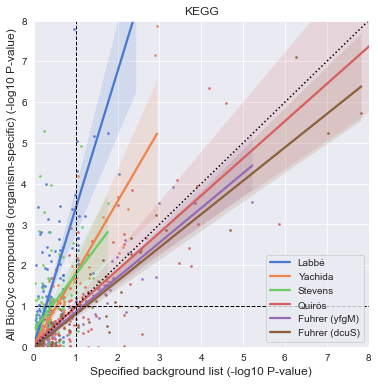

In [5]:
def plot_log_pvalues(db="KEGG"):
    d_sets = datasets
    if db == "Reactome":
        d_sets = datasets_reactome
    if db == "Cyc":
        d_sets = datasets_biocyc
    plt_dict = {}
    for i in d_sets.keys():
        ora_res = utils.over_representation_analysis(d_sets[i][0], d_sets[i][1], d_sets[i][2])
        ora_res_all = utils.over_representation_analysis(d_sets[i][0], d_sets[i][3], d_sets[i][2])
        intersect = (set(ora_res["Pathway_ID"].tolist()) & set(ora_res_all["Pathway_ID"].tolist()))
        # Ensures pathways are the same in both results (whole background can have additional pathways)
        ora_res_all = ora_res_all[ora_res_all["Pathway_ID"].isin(intersect)]
        ora_res_pvals = np.negative(np.log10(ora_res["P-value"].tolist()))
        ora_res_all_pvals = np.negative(np.log10(ora_res_all["P-value"].tolist()))
        plt_dict[i] = [ora_res_pvals, ora_res_all_pvals]

    plt.figure(figsize=(6, 6))
    sns.set_style("darkgrid")
    sns.set_palette("muted")
    for i in plt_dict.keys():
        x = plt_dict[i][0]
        y = plt_dict[i][1]
        # jittered_y = y + 0.1 * np.random.rand(len(y)) - 0.05
        # jittered_x = x + 0.1 * np.random.rand(len(x)) - 0.05
        ax = sns.regplot(x=x, y=y,
                         ci=95,
                         scatter_kws={'s': 3})
    ax.set_xlabel("Specified background list (-log10 P-value)",
                  fontsize=12)
    ax.set_ylabel("All BioCyc compounds (organism-specific) (-log10 P-value)",
                  fontsize=12)
    ax.set(ylim=(0, 8), xlim=(0, 8))
    ax.legend(plt_dict.keys())
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='black', linestyle=':')
    ax.axhline(y=1, linewidth=1, color='black', linestyle='--')
    ax.axvline(x=1, linewidth=1, color='black', linestyle='--')
    plt.title("KEGG")
#     plt.savefig("../Figures/logp_plot_BioCyc.png", dpi=300)
    plt.show()
plot_log_pvalues(db="KEGG")

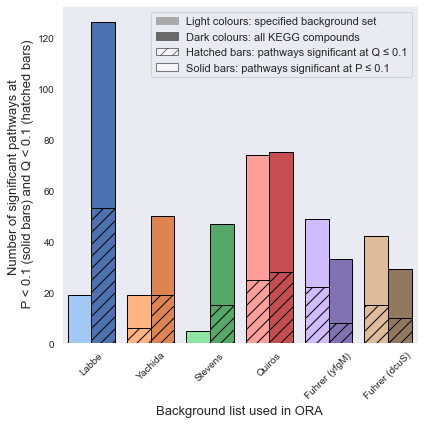

In [13]:
def plot_grouped_stacked_bar(db="KEGG"):
    dataframes = []
    d_sets = datasets
    if db == "Reactome":
        d_sets = datasets_reactome
    if db == "Cyc":
        d_sets = datasets_biocyc
    for i in d_sets.keys():
        ora_res = utils.over_representation_analysis(d_sets[i][0], d_sets[i][1], d_sets[i][2])
        ora_res_all = utils.over_representation_analysis(d_sets[i][0], d_sets[i][3], d_sets[i][2])
        intersect = (set(ora_res["Pathway_ID"].tolist()) & set(ora_res_all["Pathway_ID"].tolist()))
        # Ensures pathways are the same in both results (whole background can have additional pathways)
        ora_res_all = ora_res_all[ora_res_all["Pathway_ID"].isin(intersect)]
        n_p_less_01 = len(ora_res[ora_res["P-value"] < 0.1]["P-value"].tolist())
        n_q_less_01 = len(ora_res[ora_res["P-adjust"] < 0.1]["P-adjust"].tolist())
        n_p_less_01_all = len(ora_res_all[ora_res_all["P-value"] < 0.1]["P-value"].tolist())
        n_q_less_01_all = len(ora_res_all[ora_res_all["P-adjust"] < 0.1]["P-adjust"].tolist())
        df = pd.DataFrame([[n_q_less_01, n_p_less_01], [n_q_less_01_all, n_p_less_01_all]],
                          index=["Specified background list", "All " + db + " compounds"], columns=["P", "Q"])
        df["Name"] = i
        dataframes.append(df)

    dfall = pd.concat([pd.melt(i.reset_index(),
                               id_vars=["Name", "index"])  # transform in tidy format each df
                       for i in dataframes],
                      ignore_index=True)

    dfall.set_index(["Name", "index", "variable"], inplace=True)
    dfall["vcs"] = dfall.groupby(level=["Name", "index"]).cumsum()
    dfall.reset_index(inplace=True)
    sns.set_style("dark")
    sns.set_palette("muted")
    plt.figure(figsize=(6, 6))
    for i, g in enumerate(dfall.groupby("variable")):
        ax = sns.barplot(data=g[1],
                         x="Name",
                         y="vcs",
                         hue="index",
                         zorder=-i,  # so first bars stay on top
                         edgecolor="k",
                         ci=None)
    ax.set_xlabel('Background list used in ORA', fontsize=13)
    # ax.set_xticks(x, labels, rotation='vertical')
    ax.set_ylabel('Number of significant pathways at \n P < 0.1 (solid bars) and Q < 0.1 (hatched bars)', fontsize=13)
    # labels = ["Quirós", "Yachida", "Stevens", "Labbé", "Fuhrer (yfgM)", "Fuhrer (dcuS)"]

    # Set hatches for q-values bars
    # plt.subplots_adjust(right=0.8)
    plt.xticks(rotation=45)
    bars = ax.patches
    for i in range(6, 12):
        bars[i].set_color(sns.color_palette("deep", 6)[i - 6])
        bars[i].set_edgecolor("k")
    for i in range(0, 6):
        bars[i].set_color(sns.color_palette("pastel", 6)[i])
        bars[i].set_edgecolor("k")
    for i in range(12, 18):
        bars[i].set_color(sns.color_palette("pastel", 6)[i - 12])
        bars[i].set_edgecolor("k")
    for i in range(18, 24):
        bars[i].set_color(sns.color_palette("deep", 6)[i - 18])
        bars[i].set_edgecolor("k")
    for i in range(0, 12, 1):
        bars[i].set_hatch('//')

    specified_patch = mpatches.Patch(color='darkgray', label='Light colours: specified background set')
    unspecified_patch = mpatches.Patch(color='dimgray', label='Dark colours: all KEGG compounds')
    hatched = mpatches.Patch(facecolor='white', hatch="//", label='Hatched bars: pathways significant at Q ≤ 0.1',
                             edgecolor='k', alpha=0.5)
    solid = mpatches.Patch(facecolor='white', label='Solid bars: pathways significant at P ≤ 0.1', edgecolor='k',
                           alpha=0.5)
    plt.legend(handles=[specified_patch, unspecified_patch, hatched, solid], fontsize=11)

    # plt.title(db, fontsize=14)
    plt.tight_layout()
    # plt.savefig("../Figures/all_vs_experimental_barchart_KEGG.png", dpi=600)
    plt.show()

plot_grouped_stacked_bar(db="KEGG")

### Background list size reduction

In [18]:
np.seterr(all="ignore")
def reduce_background_set(db="KEGG"):
    percentage_reductions_keep_DEM = [i for i in range(100, 0, -10)]
    percentage_reductions = [i for i in range(100, 0, -10)]
    d_sets = datasets
    if db == "Reactome":
        d_sets = datasets_reactome
    results_lists_keep_DEM = []
    results_lists = []
    for d in d_sets.keys():
        print(d)
        for i in percentage_reductions:
            res = utils.reduce_background_list_ora(d_sets[d][1], i, d_sets[d][0], d_sets[d][2], keep_DEM=False)
            results_lists.append([d, i] + res)
        for i in percentage_reductions_keep_DEM:
            res_keep_DEM = utils.reduce_background_list_ora(d_sets[d][1], i, d_sets[d][0], d_sets[d][2], keep_DEM=True)
            results_lists_keep_DEM.append([d, i] + res_keep_DEM)

    res_df = pd.DataFrame(results_lists,
                          columns=["Dataset", "Percentage reduction", "n_p_less_0.1",
                                   "n_q_less_0.1", "mean_proportion_p_vals", "p_std",
                                   "q_std", "sd_proportion_p_vals"])
    res_df_keep_DEM = pd.DataFrame(results_lists_keep_DEM,
                                   columns=["Dataset", "Percentage reduction", "n_p_less_0.1",
                                            "n_q_less_0.1", "mean_proportion_p_vals", "p_std",
                                            "q_std", "sd_proportion_p_vals"])
    res_df_keep_DEM.to_csv("Background_reduction_simulation_keep_DEM.csv")
    res_df.to_csv("Background_reduction_simulation.csv")
    # simulation_res = pd.read_csv("Background_reduction_simulation.csv")
    # simulation_res_keep_DEM = pd.read_csv("Background_reduction_simulation_keep_DEM.csv")
    simulation_res = res_df
    simulation_res_keep_DEM = res_df_keep_DEM
    with plt.style.context('seaborn'):
        fig = plt.figure(figsize=(10, 6), dpi=600)
        gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1], sharey=ax1)
        ax1.set_title("Random background list reduction", fontsize=14)
        for i in d_sets.keys():
            if i in ["Quirós", "Fuhrer (yfgM)", "Fuhrer (dcuS)"]:
                ax1.errorbar(simulation_res[simulation_res["Dataset"] == i]['Percentage reduction'],
                             simulation_res[simulation_res["Dataset"] == i]['mean_proportion_p_vals'],
                             yerr=simulation_res[simulation_res["Dataset"] == i]['sd_proportion_p_vals'],
                             label=i, fmt='o', linestyle="--", capsize=5, markeredgewidth=2, markersize=4)
            else:
                ax1.errorbar(simulation_res[simulation_res["Dataset"] == i]['Percentage reduction'],
                             simulation_res[simulation_res["Dataset"] == i]['mean_proportion_p_vals'],
                             yerr=simulation_res[simulation_res["Dataset"] == i]['sd_proportion_p_vals'],
                             label=i, fmt='o', linestyle="solid", capsize=5, markeredgewidth=2, markersize=4)
        ax1.set_xlim(100, 10)
        ax2.set_title("No DA metabolite removal", fontsize=14)
        for i in d_sets.keys():
            if i in ["Quirós", "Fuhrer (yfgM)", "Fuhrer (dcuS)"]:
                ax2.errorbar(simulation_res_keep_DEM[simulation_res_keep_DEM["Dataset"] == i]['Percentage reduction'],
                             simulation_res_keep_DEM[simulation_res_keep_DEM["Dataset"] == i]['mean_proportion_p_vals'],
                             yerr=simulation_res_keep_DEM[simulation_res_keep_DEM["Dataset"] == i][
                                 'sd_proportion_p_vals'],
                             label=i, fmt='o', linestyle="--", capsize=5, markeredgewidth=2, markersize=4)
            else:
                ax2.errorbar(simulation_res_keep_DEM[simulation_res_keep_DEM["Dataset"] == i]['Percentage reduction'],
                             simulation_res_keep_DEM[simulation_res_keep_DEM["Dataset"] == i]['mean_proportion_p_vals'],
                             yerr=simulation_res_keep_DEM[simulation_res_keep_DEM["Dataset"] == i][
                                 'sd_proportion_p_vals'],
                             label=i, fmt='o', linestyle="solid", capsize=5, markeredgewidth=2, markersize=4)
        ax2.set_xlim(100, 10)
        handles, labels = ax1.get_legend_handles_labels()
        fig.add_subplot(111, frameon=False)
        # hide tick and tick label of the big axes
        plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        plt.grid(False)

        plt.ylabel("Proportion of pathways significant at P < 0.1 \n compared to at baseline (original background set)",
                   fontsize=13)
        plt.xlabel("Percentage of original background list", fontsize=13)
        plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=11)
        plt.tight_layout()
#         plt.savefig("background_list_reduction_proportion_KEGG.png", dpi=600)
        plt.show()


reduce_background_set(db="KEGG")

Labbé


/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


KeyboardInterrupt: 

<a id='s2'></a>
## List of input metabolites

Cutoff_P       0.001  0.005  0.010  0.050  0.100
Dataset                                         
Labbé             13     12     10     19     11
Yachida            4      4      5     13     11
Stevens            6      8      9      5      4
Quirós            58     54     54     49     41
Fuhrer (yfgM)      1      2     13      6      7
Fuhrer (dcuS)      0      4      4     11      8


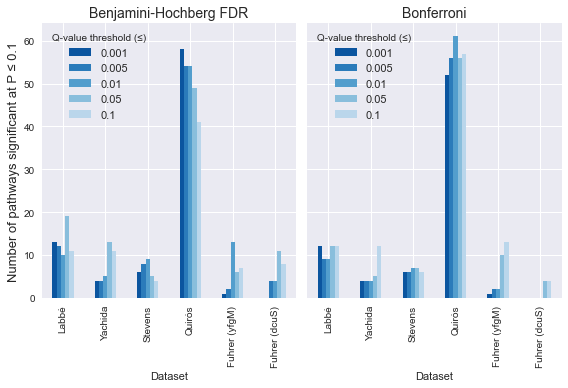

In [6]:
def vary_pval():
    cutoffs = [0.001, 0.005, 0.01, 0.05, 0.1]
    multiple_test_options = ["bonferroni", "fdr_bh"]
    res_list = []
    for d in datasets:
        for c in cutoffs:
            for m in multiple_test_options:
                if d.startswith("Fuhrer"):
                    p_vals_dict = {}
                    for x in datasets[d][4].T.itertuples():
                        zscore = x[1]
                        pval = stats.norm.cdf(zscore)
                        p_vals_dict[x[0]] = pval
                    pvals_df = pd.DataFrame.from_dict(p_vals_dict, orient='index', columns=['P-value'])
                    padj = sm.stats.multipletests(pvals_df["P-value"], 0.05, method=m)[1]
                    pvals_df['P-adjust'] = padj
                    DA_metabolites = pvals_df[pvals_df['P-adjust'] <= c].index.tolist()

                            # TODO multiple testing correction
                    ora_res = utils.over_representation_analysis(DA_metabolites, datasets[d][1], datasets[d][2])
                    res_list.append([d, c, m, len(ora_res[ora_res["P-value"] <= 0.1]["P-value"].tolist())])
                else:
                    t_test_res = utils.t_tests(datasets[d][4].iloc[:, :-1], datasets[d][4]["Group"], m)
                    DA_metabolites = t_test_res[t_test_res["P-adjust"] <= c]["Metabolite"].tolist()
                    ora_res = utils.over_representation_analysis(DA_metabolites, datasets[d][1], datasets[d][2])
                    res_list.append([d, c, m, len(ora_res[ora_res["P-value"] <= 0.1]["P-value"].tolist())])

    res_df = pd.DataFrame(res_list, columns=["Dataset", "Cutoff_P", "Multiple_correction_method", "n_p_less_01"])
    res_df.to_csv("p-value_cutoffs.csv")
    res_df = pd.read_csv("p-value_cutoffs.csv")
    res_df_FDR_BH = res_df[res_df["Multiple_correction_method"] == "fdr_bh"]
    res_df_FDR_BH = res_df_FDR_BH.drop("Multiple_correction_method", axis=1)
    res_df_FDR_BH = res_df_FDR_BH.pivot(index='Dataset', columns=['Cutoff_P'], values='n_p_less_01')
    res_df_FDR_BH = res_df_FDR_BH.reindex(list(datasets.keys()))
    print(res_df_FDR_BH)
    res_df_bonferroni = res_df[res_df["Multiple_correction_method"] == "bonferroni"]
    res_df_bonferroni = res_df_bonferroni.drop("Multiple_correction_method", axis=1)
    res_df_bonferroni = res_df_bonferroni.pivot(index='Dataset', columns=['Cutoff_P'],
                                                values='n_p_less_01')
    res_df_bonferroni = res_df_bonferroni.reindex(list(datasets.keys()))

    with plt.style.context('seaborn'):
        sns.set_palette("Blues_r")
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)

        res_df_FDR_BH.plot.bar(ax=ax1)
        ax1.set_title('Benjamini-Hochberg FDR', fontsize=14)
        ax1.set_ylabel("Number of pathways significant at P ≤ 0.1", fontsize=13)
        # plt.ylabel("Number of significant pathway at P < 0.1")
        # plt.xlabel("Dataset")
        ax1.legend(title="Q-value threshold (≤)", fontsize=11)

        res_df_bonferroni.plot.bar(ax=ax2)
        ax2.set_title('Bonferroni', fontsize=14)
        ax2.legend(title="Q-value threshold (≤)", fontsize=11)
        # plt.title('Bonferroni')
        plt.tight_layout()
#         plt.savefig("../Figures/vary_pvalue_cutoff.png", dpi=600)
        plt.show()


vary_pval()

In [ ]:
import matplotlib
def vary_dam_size_single_rankbyp(dataset):
    multiple_test_options = ["bonferroni", "fdr_bh"]
    res_list = []
    for d in [dataset]:
        print(d)
        if d.startswith("Fuhrer"):
            p_vals_dict = {}
            for x in datasets[d][4].T.itertuples():
                zscore = x[1]
                pval = stats.norm.cdf(zscore)
                p_vals_dict[x[0]] = pval
            pvals_df = pd.DataFrame.from_dict(p_vals_dict, orient='index', columns=["P-value"])
            padj = sm.stats.multipletests(pvals_df["P-value"], 0.05, method=m)[1]
            pvals_df["P-adjust"] = padj
            pvals_df["ranked_padj"] = stats.rankdata(pvals_df["P-adjust"], method='min')
            pvals_df = pvals_df.sort_values(by="ranked_padj")

            print(pvals_df)
            max_rank = pvals_df["ranked_padj"].max()
            print(max_rank)
            for i in range(1, len(pvals_df["P-adjust"]) + 1):
                metabolite_rank = pvals_df.iloc[i - 1, 2]
                DA_metabolites = pvals_df[pvals_df["ranked_padj"] <= metabolite_rank].index.tolist()
                ora_res = utils.over_representation_analysis(DA_metabolites, datasets[d][1], datasets[d][2])
                res_list.append([d, i, m, len(ora_res[ora_res["P-value"] < 0.1]["P-value"].tolist())])

        else:
            t_test_res = utils.t_tests(datasets[d][4].iloc[:, :-1], datasets[d][4]["Group"], "fdr_bh")
            t_test_res["ranked_p"] = stats.rankdata(t_test_res["P-value"], method='min')
            t_test_res = t_test_res.sort_values(by="ranked_p")
            # t_test_res.to_csv("Labbe_ttest_res" + m + ".csv")

            max_rank = t_test_res["ranked_p"].max()
            print(max_rank)
            for i in range(1, len(t_test_res["Metabolite"]) + 1):
                metabolite_rank = t_test_res.iloc[i - 1, 3]
#                 print("Metabolite:", i, "rank:", metabolite_rank)
                DA_metabolites = t_test_res[t_test_res["ranked_p"] <= metabolite_rank]["Metabolite"].tolist()
                ora_res = utils.over_representation_analysis(DA_metabolites, datasets[d][1], datasets[d][2])
                res_list.append([d, i, len(ora_res[ora_res["P-value"] < 0.1]["P-value"].tolist())])

    res_df = pd.DataFrame(res_list, columns=["Dataset", "Cutoff_P", "n_p_less_01"])

    # add annotations
    cutoffs = [0.005, 0.05, 0.1]
    annotations = []
    for d in [dataset]:
        for c in cutoffs:
            for m in multiple_test_options:
                if d.startswith("Fuhrer"):
                    p_vals_dict = {}
                    for x in datasets[d][4].T.itertuples():
                        zscore = x[1]
                        pval = stats.norm.cdf(zscore)
                        p_vals_dict[x[0]] = pval
                    pvals_df = pd.DataFrame.from_dict(p_vals_dict, orient='index', columns=["P-value"])
                    padj = sm.stats.multipletests(pvals_df["P-value"], 0.05, method=m)[1]
                    pvals_df["P-adjust"] = padj
                    DA_metabolites = pvals_df[pvals_df["P-adjust"] <= c].index.tolist()
                    percentage = (len(DA_metabolites) / len(datasets[d][1])) * 100
                    ora_res = utils.over_representation_analysis(DA_metabolites, datasets[d][1], datasets[d][2])
                    res_df.loc[len(res_df), :] = [d, percentage,
                                                  len(ora_res[ora_res["P-value"] <= 0.1]["P-value"].tolist())]

                    annotations.append(
                        [c, percentage, len(ora_res[ora_res["P-value"] <= 0.1]["P-value"].tolist()), d, m])
                else:
                    t_test_res = utils.t_tests(datasets[d][4].iloc[:, :-1], datasets[d][4]["Group"], m)
                    DA_metabolites = t_test_res[t_test_res["P-adjust"] <= c]["Metabolite"].tolist()
                    n_DA = len(DA_metabolites)
                    ora_res = utils.over_representation_analysis(DA_metabolites, datasets[d][1], datasets[d][2])
                    res_df.loc[len(res_df), :] = [d, n_DA,
                                                  len(ora_res[ora_res["P-value"] <= 0.1]["P-value"].tolist())]

                    annotations.append(
                        [c, n_DA, len(ora_res[ora_res["P-value"] <= 0.1]["P-value"].tolist()), d, m])

    cutoffs_df = pd.DataFrame(annotations)
    cutoffs_bonferroni = cutoffs_df[cutoffs_df[4] == "bonferroni"]
    cutoffs_FDR_BH = cutoffs_df[cutoffs_df[4] == "fdr_bh"]
    res_df = res_df.sort_values(by='Cutoff_P')

    print(res_df)
    with plt.style.context('seaborn-darkgrid'):
        fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))
        cols = sns.color_palette("muted", 8)
        for num, i in enumerate([dataset]):
            ax1.plot(res_df[res_df["Dataset"] == i]['Cutoff_P'].to_list(),
                     res_df[res_df["Dataset"] == i]['n_p_less_01'].tolist(), 'o',
                     label=i, linestyle='-', color=cols[num], markersize=2)

        for num, i in enumerate(cutoffs_bonferroni.itertuples()):
            if i[1] == 0.005:
                ax1.annotate('*', xy=(i[2], i[3]), fontsize=14)
            elif i[1] == 0.05:
                ax1.annotate('**', xy=(i[2], i[3]), fontsize=14)
            elif i[1] == 0.1:
                ax1.annotate('***', xy=(i[2], i[3]), fontsize=14)
        for num, i in enumerate(cutoffs_FDR_BH.itertuples()):
            if i[1] == 0.005:
                ax1.annotate('*', xy=(i[2]+0.5, i[3]+0.001), fontsize=14, color="red")
            elif i[1] == 0.05:
                ax1.annotate('**', xy=(i[2], i[3]), fontsize=14, color="red")
            elif i[1] == 0.1:
                ax1.annotate('***', xy=(i[2], i[3]), fontsize=14, color="red")
        
        def create_proxy(label):
            line = matplotlib.lines.Line2D([0], [0], linestyle='none', mfc='black',
                mec='none', marker=r'$\mathregular{{{}}}$'.format(label), markersize=12)
            return line
        
        handles, labels = ax1.get_legend_handles_labels()

        patch = matplotlib.lines.Line2D([], [], color='black', linestyle='None',
                          markersize=8, label='P ≤ 0.005', marker=r'$\mathregular{{{}}}$'.format("*"))
        patch2 = matplotlib.lines.Line2D([], [], color='black', linestyle='None',
                          markersize=10, label='P ≤ 0.05', marker=r'$\mathregular{{{}}}$'.format("**"))
        patch3 = matplotlib.lines.Line2D([], [], color='black', linestyle='None',
                          markersize=13, label='P ≤ 0.1', marker=r'$\mathregular{{{}}}$'.format("***"))
        patch4 = matplotlib.lines.Line2D([], [], color='red', linestyle='None',
                          markersize=8, label='Q ≤ 0.005', marker=r'$\mathregular{{{}}}$'.format("*"))
        patch5 = matplotlib.lines.Line2D([], [], color='red', linestyle='None',
                          markersize=10, label='Q ≤ 0.05', marker=r'$\mathregular{{{}}}$'.format("**"))
        patch6 = matplotlib.lines.Line2D([], [], color='red', linestyle='None',
                          markersize=13, label='Q ≤ 0.1', marker=r'$\mathregular{{{}}}$'.format("***"))

        for p in [patch, patch2, patch3, patch4, patch5, patch6]:
            handles.append(p)
        plt.legend(handles=handles, fontsize=11)

        ax1.set_ylabel("Number of pathways significant at P ≤ 0.1", fontsize=13)
        ax1.set_xlabel("Top N metabolites (ranked by raw P-value)", fontsize=13)

#         plt.savefig("../Figures/vary_input_metabolites_Labbe.png", dpi=600)
        plt.show()


vary_dam_size_single_rankbyp("Labbé")


Labbé
Yachida
Stevens
Quirós
Fuhrer (yfgM)
Fuhrer (dcuS)
[<matplotlib.lines.Line2D object at 0x7ff348991130>, <matplotlib.lines.Line2D object at 0x7ff348991310>, <matplotlib.lines.Line2D object at 0x7ff34660a700>, <matplotlib.lines.Line2D object at 0x7ff3489915e0>, <matplotlib.lines.Line2D object at 0x7ff348991910>, <matplotlib.lines.Line2D object at 0x7ff348991c40>] ['Labbé', 'Yachida', 'Stevens', 'Quirós', 'Fuhrer (yfgM)', 'Fuhrer (dcuS)']


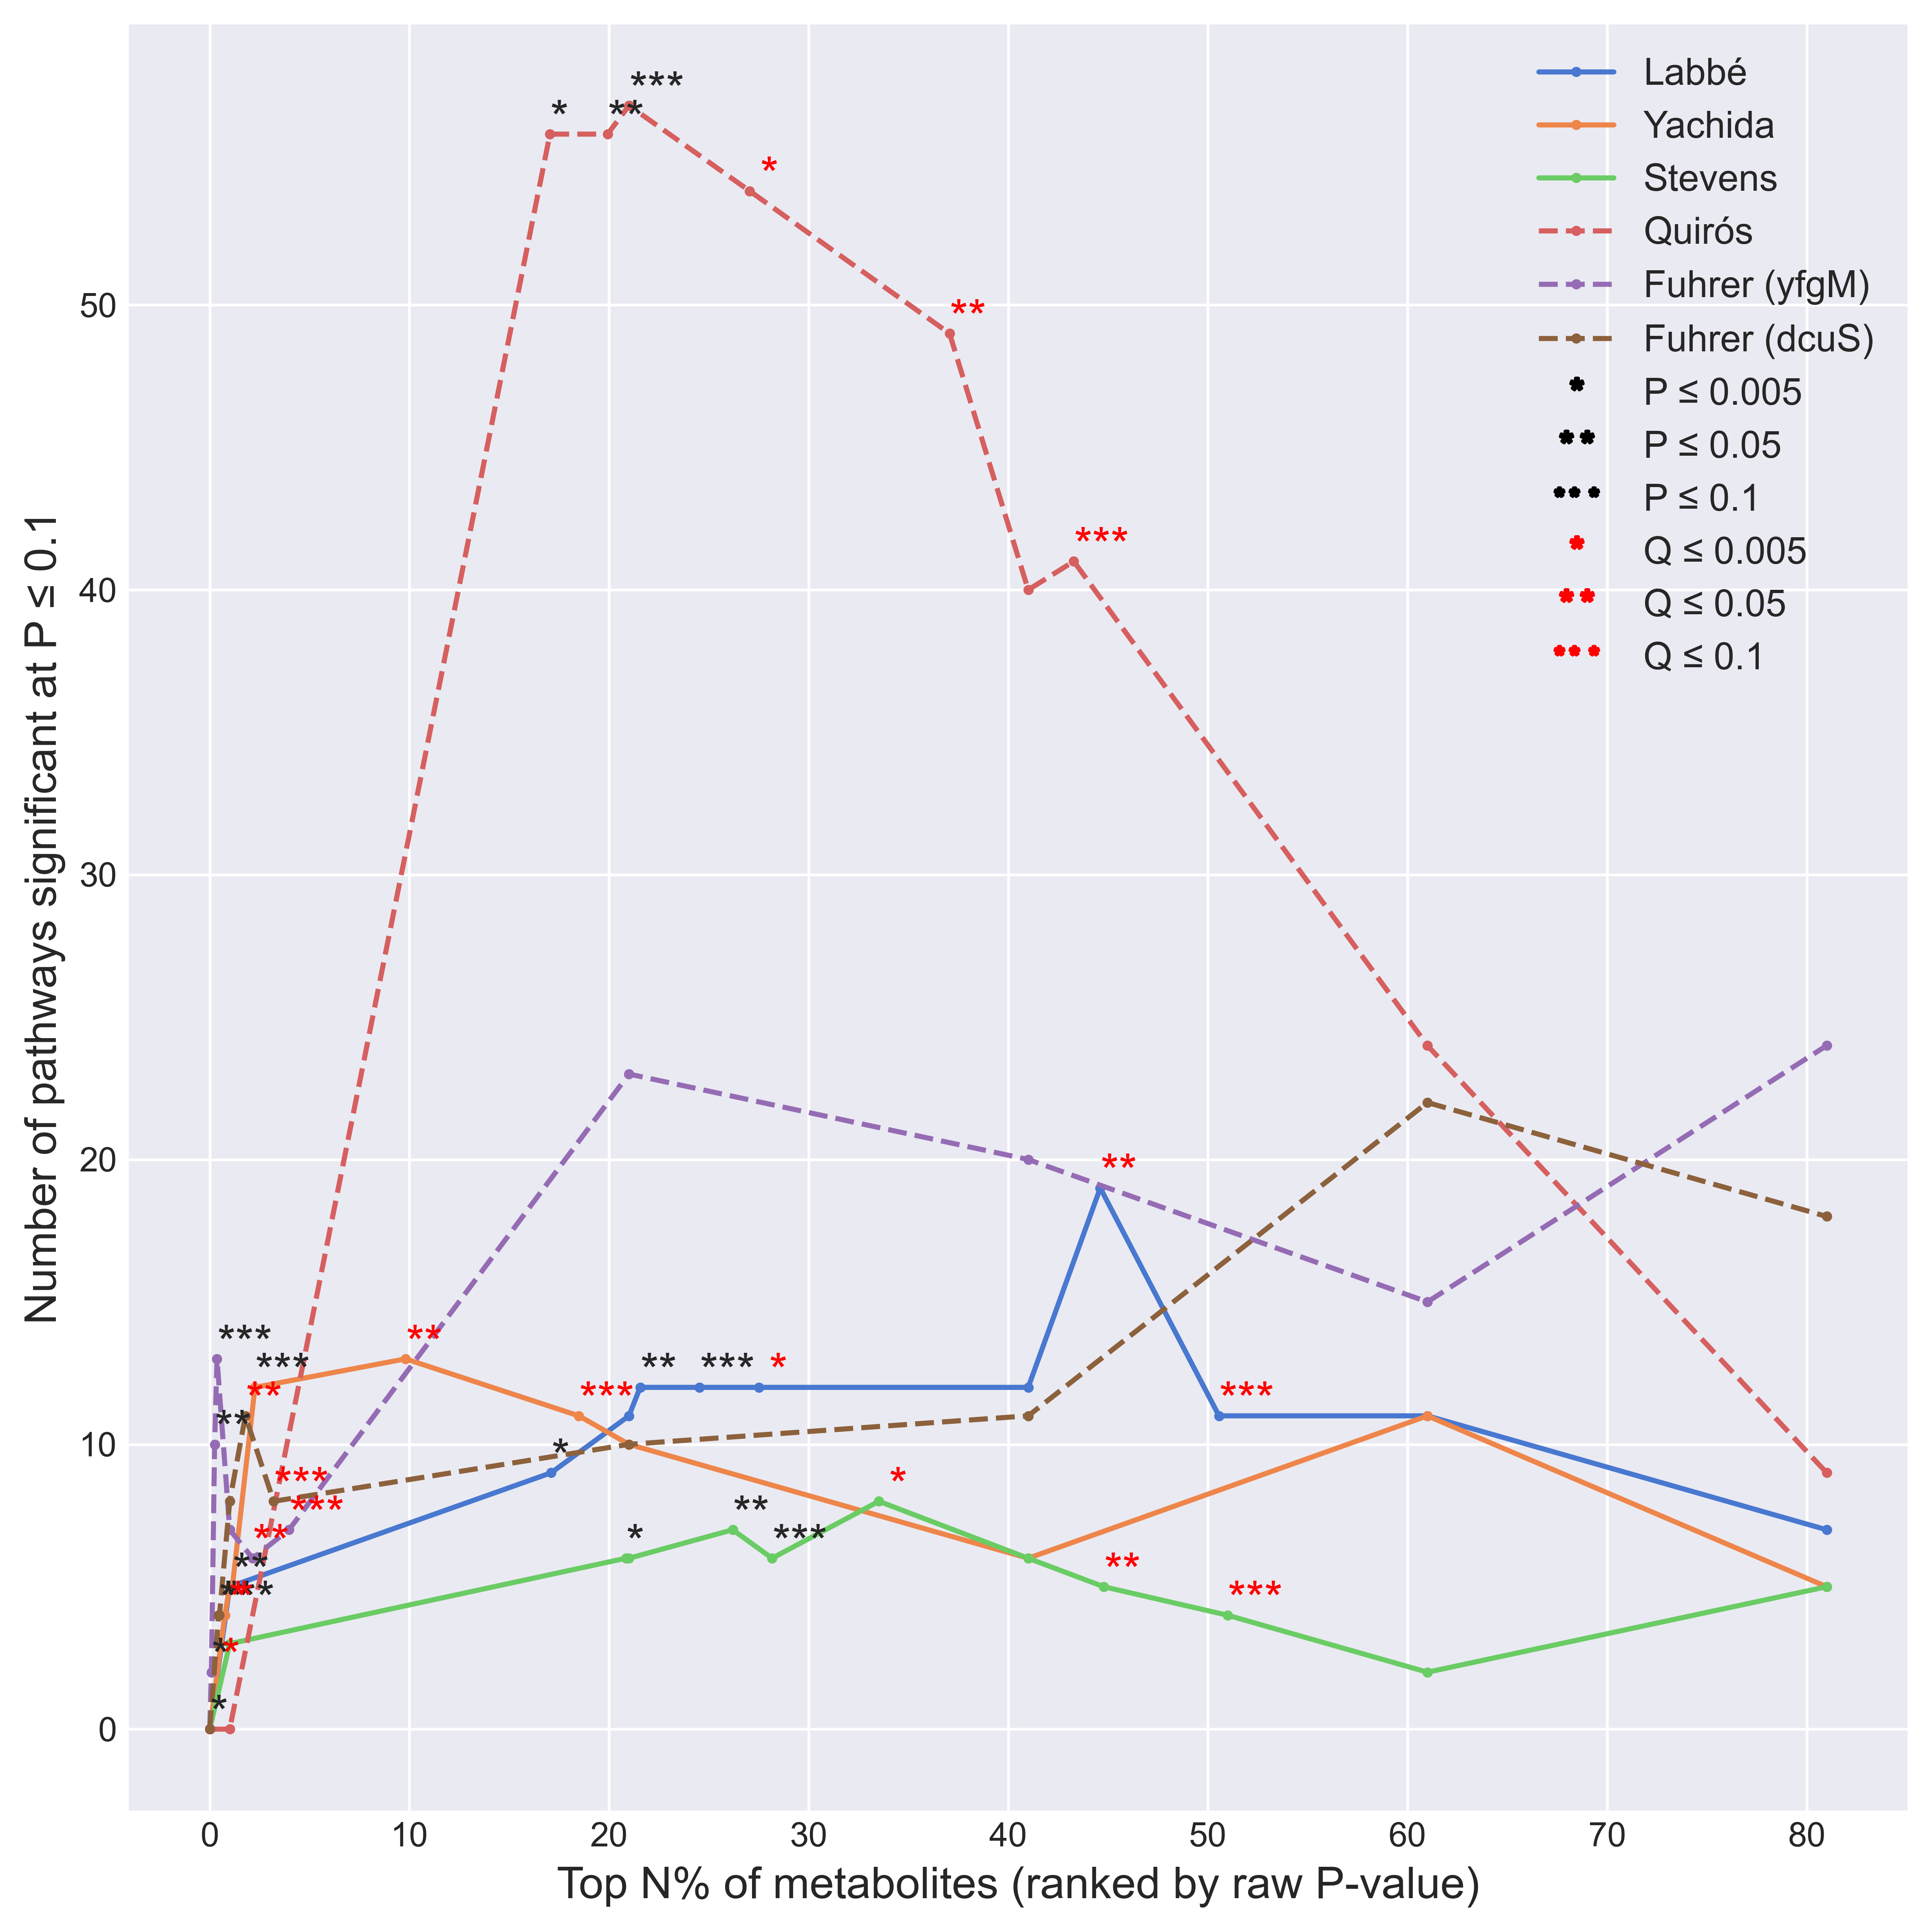

In [14]:
def vary_dam_size_rankbyP():
    proportion_of_bg = [i for i in range(1, 101, 1)]
    multiple_test_options = ["bonferroni", "fdr_bh"]
    res_list = []
    for d in datasets.keys():
        res_list.append([d, 0, 0])
        print(d)
        for p in proportion_of_bg:
            if d.startswith("Fuhrer"):
                p_vals_dict = {}
                for x in datasets[d][4].T.itertuples():
                    zscore = x[1]
                    pval = stats.norm.cdf(zscore)
                    p_vals_dict[x[0]] = pval
                pvals_df = pd.DataFrame.from_dict(p_vals_dict, orient='index', columns=["P-value"])
                padj = sm.stats.multipletests(pvals_df["P-value"], 0.05, method="fdr_bh")[1]
                pvals_df["P-adjust"] = padj
                pvals_df["ranked_p"] = stats.rankdata(pvals_df["P-value"], method='min')
                pvals_df = pvals_df.sort_values(by="ranked_p")
                select_up_to = int((len(pvals_df["P-value"]) - 1) * (p / 100))
                selected_rank = pvals_df.iloc[select_up_to, 2]
                DA_metabolites = pvals_df[pvals_df["ranked_p"] <= selected_rank].index.tolist()
                ora_res = utils.over_representation_analysis(DA_metabolites, datasets[d][1], datasets[d][2])
                res_list.append([d, p, len(ora_res[ora_res["P-value"] < 0.1]["P-value"].tolist())])
            else:
                t_test_res = utils.t_tests(datasets[d][4].iloc[:, :-1], datasets[d][4]["Group"], "fdr_bh")
                t_test_res["ranked_p"] = stats.rankdata(t_test_res["P-value"], method='min')
                t_test_res = t_test_res.sort_values(by="ranked_p")
                select_up_to = int((len(t_test_res["Metabolite"]) - 1) * (p / 100))
                selected_rank = t_test_res.iloc[select_up_to, 3]
                DA_metabolites = t_test_res[t_test_res["ranked_p"] <= selected_rank]["Metabolite"].tolist()
                ora_res = utils.over_representation_analysis(DA_metabolites, datasets[d][1], datasets[d][2])
                res_list.append([d, p, len(ora_res[ora_res["P-value"] < 0.1]["P-value"].tolist())])
    res_df = pd.DataFrame(res_list, columns=["Dataset", "Cutoff_P", "n_p_less_01"])

    # add annotations
    cutoffs = [0.005, 0.05, 0.1]
    annotations = []
    for d in datasets.keys():
        for c in cutoffs:
            for m in multiple_test_options:
                if d.startswith("Fuhrer"):
                    p_vals_dict = {}
                    for x in datasets[d][4].T.itertuples():
                        zscore = x[1]
                        pval = stats.norm.cdf(zscore)
                        p_vals_dict[x[0]] = pval
                    pvals_df = pd.DataFrame.from_dict(p_vals_dict, orient='index', columns=["P-value"])
                    padj = sm.stats.multipletests(pvals_df["P-value"], 0.05, method=m)[1]
                    pvals_df["P-adjust"] = padj
                    DA_metabolites = pvals_df[pvals_df["P-adjust"] <= c].index.tolist()
                    percentage = (len(DA_metabolites) / len(datasets[d][1])) * 100
                    ora_res = utils.over_representation_analysis(DA_metabolites, datasets[d][1], datasets[d][2])
                    res_df.loc[len(res_df), :] = [d, percentage,
                                                  len(ora_res[ora_res["P-value"] <= 0.1]["P-value"].tolist())]

                    annotations.append(
                        [c, percentage, len(ora_res[ora_res["P-value"] <= 0.1]["P-value"].tolist()), d, m])
                else:
                    t_test_res = utils.t_tests(datasets[d][4].iloc[:, :-1], datasets[d][4]["Group"], m)
                    DA_metabolites = t_test_res[t_test_res["P-adjust"] <= c]["Metabolite"].tolist()
                    percentage = (len(DA_metabolites) / len(t_test_res["Metabolite"])) * 100
                    ora_res = utils.over_representation_analysis(DA_metabolites, datasets[d][1], datasets[d][2])
                    res_df.loc[len(res_df), :] = [d, percentage,
                                                  len(ora_res[ora_res["P-value"] <= 0.1]["P-value"].tolist())]

                    annotations.append(
                        [c, percentage, len(ora_res[ora_res["P-value"] <= 0.1]["P-value"].tolist()), d, m])

    cutoffs_df = pd.DataFrame(annotations)
    cutoffs_bonferroni = cutoffs_df[cutoffs_df[4] == "bonferroni"]
    cutoffs_FDR_BH = cutoffs_df[cutoffs_df[4] == "fdr_bh"]

    res_df = res_df.sort_values(by='Cutoff_P')

    with plt.style.context('seaborn-darkgrid'):
        fig, ax1 = plt.subplots(1, 1, figsize=(8, 8), dpi=600)
        cols = sns.color_palette("muted", 8)
        for num, i in enumerate(datasets.keys()):
            if i in ["Quirós", "Fuhrer (yfgM)", "Fuhrer (dcuS)"]:
                ax1.plot(res_df[res_df["Dataset"] == i]['Cutoff_P'].to_list(),
                         res_df[res_df["Dataset"] == i]['n_p_less_01'].tolist(), 'o',
                         label=i, linestyle='--', color=cols[num], markersize=2)
            else:
                ax1.plot(res_df[res_df["Dataset"] == i]['Cutoff_P'].to_list(),
                         res_df[res_df["Dataset"] == i]['n_p_less_01'].tolist(), 'o',
                         label=i, linestyle='-', color=cols[num], markersize=2)

        for num, i in enumerate(cutoffs_bonferroni.itertuples()):
            if i[1] == 0.005:
                ax1.annotate('*', xy=(i[2], i[3]), fontsize=14)
            elif i[1] == 0.05:
                ax1.annotate('**', xy=(i[2], i[3]), fontsize=14)
            elif i[1] == 0.1:
                ax1.annotate('***', xy=(i[2], i[3]), fontsize=14)
        for num, i in enumerate(cutoffs_FDR_BH.itertuples()):
            if i[1] == 0.005:
                ax1.annotate('*', xy=(i[2]+0.5, i[3]+0.001), fontsize=14, color="red")
            elif i[1] == 0.05:
                ax1.annotate('**', xy=(i[2], i[3]), fontsize=14, color="red")
            elif i[1] == 0.1:
                ax1.annotate('***', xy=(i[2], i[3]), fontsize=14, color="red")
        
        def create_proxy(label):
            line = matplotlib.lines.Line2D([0], [0], linestyle='none', mfc='black',
                mec='none', marker=r'$\mathregular{{{}}}$'.format(label), markersize=12)
            return line
        
        handles, labels = ax1.get_legend_handles_labels()
        print(handles, labels)

        patch = matplotlib.lines.Line2D([], [], color='black', linestyle='None',
                          markersize=8, label='P ≤ 0.005', marker=r'$\mathregular{{{}}}$'.format("*"))
        patch2 = matplotlib.lines.Line2D([], [], color='black', linestyle='None',
                          markersize=10, label='P ≤ 0.05', marker=r'$\mathregular{{{}}}$'.format("**"))
        patch3 = matplotlib.lines.Line2D([], [], color='black', linestyle='None',
                          markersize=13, label='P ≤ 0.1', marker=r'$\mathregular{{{}}}$'.format("***"))
        patch4 = matplotlib.lines.Line2D([], [], color='red', linestyle='None',
                          markersize=8, label='Q ≤ 0.005', marker=r'$\mathregular{{{}}}$'.format("*"))
        patch5 = matplotlib.lines.Line2D([], [], color='red', linestyle='None',
                          markersize=10, label='Q ≤ 0.05', marker=r'$\mathregular{{{}}}$'.format("**"))
        patch6 = matplotlib.lines.Line2D([], [], color='red', linestyle='None',
                          markersize=13, label='Q ≤ 0.1', marker=r'$\mathregular{{{}}}$'.format("***"))

        for p in [patch, patch2, patch3, patch4, patch5, patch6]:
            handles.append(p)
        ax1.legend(handles=handles, fontsize=11)

#         ax1.legend(fontsize=11)
        ax1.set_ylabel("Number of pathways significant at P ≤ 0.1", fontsize=13)
        ax1.set_xlabel("Top N% of metabolites (ranked by raw P-value)", fontsize=13)
        plt.tight_layout()
        plt.savefig("vary_input_metabolites_all_new2.png", dpi=600)
        plt.show()


vary_dam_size_rankbyP()


<a id='s3'></a>
## General vs. organism-specific pathway set

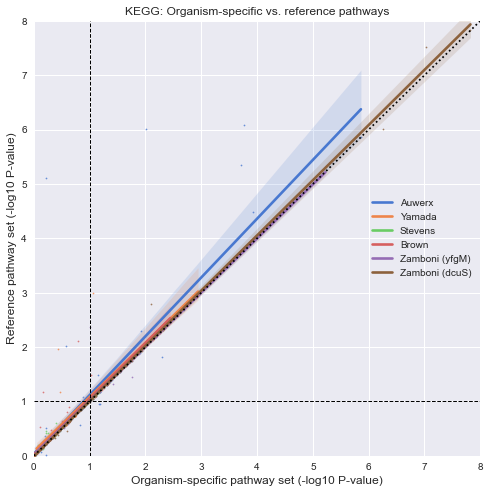

In [20]:
def organism_vs_reference(db="KEGG"):
    d_sets = datasets
    # if db == "Reactome":
    #     d_sets = datasets_reactome
    # if db == "Cyc":
    #     d_sets = datasets_biocyc
    plt_dict = {}
    for i in d_sets.keys():
        ora_res_org = utils.over_representation_analysis(d_sets[i][0], d_sets[i][1], d_sets[i][2])
        ora_res_ref = utils.over_representation_analysis(d_sets[i][0], d_sets[i][1], KEGG_reference_pathways)
        intersect = (set(ora_res_org["Pathway_ID"].str.slice(start=-5).tolist()) & set(ora_res_ref["Pathway_ID"].str.slice(start=-5).tolist()))
        # Ensures pathways are the same in both results (whole background can have additional pathways)
        ora_res_ref = ora_res_ref[ora_res_ref["Pathway_ID"].str.slice(start=-5).isin(intersect)]
        ora_res_org = ora_res_org[ora_res_org["Pathway_ID"].str.slice(start=-5).isin(intersect)]
        ora_res_org_pvals = np.negative(np.log10(ora_res_org["P-value"].tolist()))
        ora_res_ref_pvals = np.negative(np.log10(ora_res_ref["P-value"].tolist()))
        plt_dict[i] = [ora_res_org_pvals, ora_res_ref_pvals]

    plt.figure(figsize=(8, 8))
    sns.set_style("darkgrid")
    sns.set_palette("muted")
    for i in plt_dict.keys():
        x = plt_dict[i][0]
        y = plt_dict[i][1]

        ax = sns.regplot(x=x, y=y,
                         ci=95,
                         scatter_kws={'s': 3})
    ax.set_xlabel("Organism-specific pathway set (-log10 P-value)",
                  fontsize=12)
    ax.set_ylabel("Reference pathway set (-log10 P-value)",
                  fontsize=12)
    ax.set(ylim=(0, 8), xlim=(0, 8))
    ax.legend(plt_dict.keys())
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='black', linestyle=':')
    ax.axhline(y=1, linewidth=1, color='black', linestyle='--')
    ax.axvline(x=1, linewidth=1, color='black', linestyle='--')
    plt.title("KEGG: Organism-specific vs. reference pathways")
#     plt.savefig("../Figures/organism_vs_reference_pathways_pvals.png", dpi=300)
    plt.show()

organism_vs_reference()

#### Calculate average pathway size

In [2]:
def process_paths(pathway_df):
    KEGG_pathways = pathway_df.dropna(axis=0, how='all', subset=pathway_df.columns.tolist()[1:])
    pathways = KEGG_pathways.index.tolist()
    pathway_names = KEGG_pathways["Pathway_name"].tolist()
    pathway_dict = {}

    for pathway in pathways:
        pathway_compounds = KEGG_pathways.loc[pathway, :].tolist()
        pathway_compounds = [str(i) for i in pathway_compounds if str(i) != "nan"]
        cpds = pathway_compounds[1:]
        if len(cpds) > 2:
            pathway_dict[pathway] = cpds
    return pathway_dict

In [15]:
ref_paths = process_paths(KEGG_reference_pathways)
human_paths = process_paths(KEGG_human_pathways)
avg_ref_pathway_size = np.mean([len(v) for k, v in ref_paths.items()])
avg_hum_pathway_size = np.mean([len(v) for k, v in human_paths.items()])
# mouse_pathway_size = 
# eco_pathway_size = 
print("Average reference pathway size:", avg_ref_pathway_size)
print("Average human pathway size:", avg_hum_pathway_size)
print("Total reference pathways:", len(ref_paths))
print("Total human pathways:", len(human_paths))

Average reference pathway size: 44.88859416445624
Average human pathway size: 29.582375478927204
Total reference pathways: 377
Total human pathways: 261


#### Calculate Jaccard index for common pathways

In [13]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [31]:
common_paths_ref_human = list(set([i[3:] for i in ref_paths.keys()]) & set([i[3:] for i in human_paths.keys()]))

jaccard_indexes_human_ref = []
for pathway_id in common_paths_ref_human:
    jaccard_index = jaccard_similarity(ref_paths["map"+str(pathway_id)], human_paths["hsa"+str(pathway_id)])
    jaccard_indexes_human_ref.append(jaccard_index)
    
print("Average Jaccard index for common reference and human pathways:", np.mean(jaccard_indexes_human_ref))

Average Jaccard index for common reference and human pathways: 0.7489924529127291


<a id='s4'></a>
## Database updates

### KEGG 2015-2020

In [8]:
KEGG_hum_2020 = process_paths(pd.read_csv("Old_KEGG/PathwayMetabolite6196_human_latest.csv", dtype=str, index_col=0, engine='python'))
KEGG_hum_2017 = process_paths(pd.read_csv("Old_KEGG/PathwayMetabolite5070_human_08_2017.csv", dtype=str, index_col=0, engine='python'))
KEGG_hum_2015 = process_paths(pd.read_csv("Old_KEGG/PathwayMetabolite2903_human_04_2015.csv", dtype=str, index_col=0, engine='python'))
years = {"KEGG_2020": KEGG_hum_2020, "KEGG_2017": KEGG_hum_2017, "KEGG_2015": KEGG_hum_2015}
print(len(KEGG_hum_2015))

87


In [9]:
pathway_stats = pd.DataFrame(index=["KEGG_2020", "KEGG_2017", "KEGG_2015"], columns=["Number of pathways", "Number of unique compounds", "Mean pathway length"])
for db in pathway_stats.index:
    pathway_stats.loc[db, "Number of pathways"] = len(years[db])
    pathway_stats.loc[db, "Number of unique compounds"] = len(set([item for sublist in years[db].values() for item in sublist]))
    pathway_stats.loc[db, "Mean pathway length"] = np.mean([len(i) for i in years[db].values()])

In [10]:
pathway_stats

Number of pathways Number of unique compounds Mean pathway length
KEGG_2020                 89                       1618           40.404494
KEGG_2017                 87                       1572           36.666667
KEGG_2015                 87                       1560           37.298851

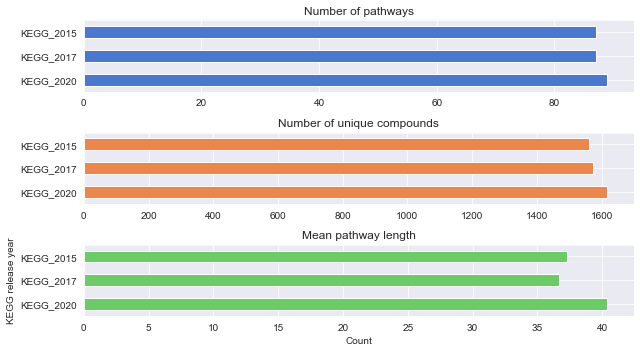

In [11]:
sns.set_style("darkgrid")
sns.set_palette("muted")
pathway_stats.plot.barh(figsize=(9, 5), subplots=True, sharex=False, sharey=True, legend=False)
plt.xlabel("Count")
plt.ylabel("KEGG release year")
plt.tight_layout()
plt.savefig("../Figures/KEGG_years_comparison.png", dpi=600)

### Reactome (release 60-75)
Reactome has 4 major releases per year. 

In [15]:
def process_reactome_file(fname):
    infile = pd.read_csv(fname, sep="\t", header=None)
    infile = infile.astype(str)
    name_dict = dict(zip(infile[1], infile[3]))

    groups = infile.groupby([1])[0].apply(list).to_dict()
    df = pd.DataFrame.from_dict(groups, orient='index')
    pathway_ids = df.index.tolist()

    df['Pathway_name'] = df.index.map(name_dict)
    col = df.pop("Pathway_name")
    df.insert(0, "Pathway_name", col)
    return df

def process_paths(pathway_df):
    KEGG_pathways = pathway_df.dropna(axis=0, how='all', subset=pathway_df.columns.tolist()[1:])
    pathways = KEGG_pathways.index.tolist()
    pathway_names = KEGG_pathways["Pathway_name"].tolist()
    pathway_dict = {}

    for pathway in pathways:
        pathway_compounds = KEGG_pathways.loc[pathway, :].tolist()
        pathway_compounds = [str(i) for i in pathway_compounds if str(i) != "None"]
        
        cpds = pathway_compounds[1:]
        if len(cpds) > 2:
            pathway_dict[pathway] = cpds
    return pathway_dict

In [16]:
import os

reactome_pathway_sets = []

directory = r"Old_Reactome"
for filename in os.listdir(directory):
    if filename.startswith("ChEBI2Reactome"):
        processed_df = process_reactome_file("Old_Reactome/"+filename)
        Reactome_human_pathways = processed_df[processed_df.index.str.contains("HSA")]
        reactome_pathway_sets.append({filename[15:18] : Reactome_human_pathways})


In [17]:
Reactome_pathway_dicts = {}
for i in reactome_pathway_sets:
    for k, v in i.items():

        reactome_dict = process_paths(v)
        Reactome_pathway_dicts.update({k: reactome_dict})

['Interleukin-6 signaling', '15422', '16761']
['Cleavage of Growing Transcript in the Termination Region ', '15422']
['PI3K Cascade', '15422', '16618', '16761', '18348', '28815']
['MAPK3 (ERK1) activation', '15422', '16761']
['Translesion synthesis by REV1', '16311', '16516', '29888']
['Translesion Synthesis by POLH', '15422', '16284', '16516', '16761', '29888']
['Cleavage of the damaged pyrimidine ', '15901', '17568', '17821', '27983', '29115', '29127', '29128', '29145', '29147']
['Cleavage of the damaged purine', '16708', '17368', '29146', '38635', '44605']
['POLB-Dependent Long Patch Base Excision Repair', '15377', '15846', '16516', '16960', '17154', '29888', '57967']
['Resolution of AP sites via the multiple-nucleotide patch replacement pathway', '16516', '29888']
['Resolution of AP sites via the single-nucleotide replacement pathway', '16516', '29888']
['Activation of BAD and translocation to mitochondria ', '15377', '15422', '16761', '18367']
['Formation of apoptosome', '15422', 

['Defective SLC35A3 causes arthrogryposis, mental retardation, and seizures (AMRS)', '16264', '16695']
['Defective SLC26A3 causes congenital secretory chloride diarrhea 1 (DIAR1)', '17544', '17996']
['Defective SLC12A3 causes Gitelman syndrome (GS)', '17996', '29101']
['Defective SLC39A4 causes acrodermatitis enteropathica, zinc-deficiency type (AEZ)', '29105']
['Defective SLC6A5 causes hyperekplexia 3 (HKPX3)', '17996', '29101', '57305']
['Defective SLC9A6 causes  X-linked, syndromic mental retardation,, Christianson type (MRXSCH)', '15378', '29101']
['Variant SLC6A14 may confer susceptibility towards obesity', '16958', '17996', '29101', '32513', '32551', '32682', '33384', '35235', '57305', '57427', '57762', '57844', '57912', '57972', '58045']
['Defective SLCO2A1 causes primary, autosomal recessive hypertrophic osteoarthropathy 2 (PHOAR2)', '15544', '15551', '15553', '15555']
['Defective SLC5A5 causes thyroid dyshormonogenesis 1 (TDH1)', '16382', '29101']
['Defective SLC34A3 causes He

['Signalling to ERK5', '30616', '456216']
['Immunoregulatory interactions between a Lymphoid and a non-Lymphoid cell', '15440', '16038', '17517', '17761', '18303', '28874', '28879', '36080', '42782', '528825', '59228', '59235', '59524', '60366', '60453', '61048', '62113', '62384', '68524', '77480']
['PPARA activates gene expression', '15756', '15756', '15843', '15843', '16325', '16755', '17351', '17351', '27432', '27432', '28119', '28364', '28364', '28834', '29105', '34154', '34496', '36144', '50122', '61120', '61120', '8228']
['Vitamin B5 (pantothenate) metabolism', '15346', '15377', '16753', '16858', '17141', '17985', '29101', '7916']
['Negative regulation of the PI3K/AKT network', '15377', '16618', '18348', '18367', '29035']
['CREB phosphorylation', '30616', '456216']
['trans-Golgi Network Vesicle Budding', '15996', '17552']
['Carnitine metabolism', '15346', '15351', '15367', '15525', '15531', '17126', '17490', '17544', '18367', '29035', '29101', '30616', '30769', '456216']
['Signal

['Defective CYP21A2 causes Adrenal hyperplasia 3 (AH3)', '15378', '15379', '16474', '17026']
['Defective GGT1 causes Glutathionuria (GLUTH)', '15377', '16856']
['Defective MAT1A causes Methionine adenosyltransferase deficiency (MATD)', '15377', '18420', '29103', '30616', '57844']
['Defective CYP11A1 causes Adrenal insufficiency, congenital, with 46,XY sex reversal (AICSR)', '1294', '15378', '15379', '16474', '33738']
['Defective CYP2R1 causes Rickets vitamin D-dependent 1B (VDDR1B)', '15378', '15379', '16474', '28940']
['Defective CYP17A1 causes Adrenal hyperplasia 5 (AH5)', '15378', '15379', '16474', '16581', '17026', '17252']
['Defective CYP19A1 causes Aromatase excess syndrome (AEXS)', '15378', '15379', '16422', '16474']
['Defective TBXAS1 causes Ghosal hematodiaphyseal dysplasia (GHDD)', '15554']
['PIWI-interacting RNA (piRNA) biogenesis', '15414', '16680', '16991', '33697', '33697']
['TLR3 deficiency - HSE', '67208']
['MyD88 deficiency (TLR2/4)', '16412', '18348', '28640', '46896'

['AMPK inhibits chREBP transcriptional activation activity', '16027', '16027', '30616', '456216']
['Integration of energy metabolism', '57737']
['Insulin effects increased synthesis of Xylulose-5-Phosphate', '15721', '15946', '16897', '18420', '29052', '57737', '58937', '78679']
['PP2A-mediated dephosphorylation of key metabolic factors', '15377', '18367']
['Gamma carboxylation, hypusine formation and arylsulfatase activation', '15414', '16680', '24103', '29105', '30616', '456216', '86019', '87167', '87176', '87177', '87178', '87179', '87180']
['PKA activation in glucagon signalling', '15996', '17489', '18420', '29888', '30616']
['Minus-strand DNA synthesis', '16516', '29888']
['Rev-mediated nuclear export of HIV RNA', '15996', '17552', '18367']
['Collagen biosynthesis and modifying enzymes', '15379', '16526', '16810', '17659', '18066', '18307', '29033', '29073', '30031']
['Activation of AKT2', '16618', '30616', '456216']
['mTOR signalling', '15996', '17552', '30616', '32682', '456216'

['Regulation of FZD by ubiquitination', '15377']
['Defective MPDU1 causes MPDU1-CDG (CDG-1f)', '15809', '53022', '53023', '59088', '59091']
['Defective DPM1 causes DPM1-CDG (CDG-1e)', '15750', '15820']
['Defective DPM3 causes DPM3-CDG (CDG-1o)', '15750', '15820']
['Defective DPM2 causes DPM2-CDG (CDG-1u)', '15750', '15820']
['Defective ALG9 causes ALG9-CDG (CDG-1l)', '15809', '53023', '59091']
['Defective ALG3 causes ALG3-CDG (CDG-1d)', '15809', '53022']
['Defective ALG12 causes ALG12-CDG (CDG-1g)', '15809', '59088']
['Defective ALG6 causes ALG6-CDG (CDG-1c)', '15812', '37637']
['Defective ALG8 causes ALG8-CDG (CDG-1h)', '15812', '59081']
['SUMOylation of immune response proteins', '4705']
['Defective SRD5A3 causes SRD5A3-CDG (CDG-1q) and KHRZ', '16474', '67132']
['Defective DOLK causes DOLK-CDG (CDG-1m)', '16091', '17677']
['Defective DHDDS causes retinitis pigmentosa 59', '16584', '17407']
['Defective MAN1B1 causes MRT15', '15377', '59092', '60627']
['Defective MGAT2 causes MGAT2-CDG

['Rev-mediated nuclear export of HIV RNA', '15996', '17552', '18367']
['Collagen biosynthesis and modifying enzymes', '15379', '15741', '16526', '17659', '18066', '18248', '18307', '29073', '30915']
['Activation of AKT2', '15422', '16618', '16761']
['mTOR signalling', '15422', '15996', '16761', '17552', '32682']
['PDE3B signalling', '15377', '15422', '16027', '16618', '16761', '17489']
['Inhibition of TSC complex formation by PKB', '15422', '16618', '16761']
['Regulation of cholesterol biosynthesis by SREBP (SREBF)', '15996', '15996', '16113', '53030']
['Toll Like Receptor 4 (TLR4) Cascade', '16412']
['Transfer of LPS from LBP carrier to CD14', '16412']
['Synthesis of PIPs at the plasma membrane', '15377', '15377', '15422', '15996', '16152', '16500', '16500', '16618', '16749', '16749', '16761', '16851', '16851', '17283', '17283', '17526', '18348', '18367', '18367', '18420', '29035', '29108']
['PIPs transport between early and late endosome membranes', '16851']
['PIPs transport between 

['Defective ALG8 causes ALG8-CDG (CDG-1h)', '15812', '59081']
['Defective SRD5A3 causes SRD5A3-CDG (CDG-1q) and KHRZ', '16474', '67132']
['Defective DOLK causes DOLK-CDG (CDG-1m)', '16091', '17677']
['Defective DHDDS causes retinitis pigmentosa 59', '16584', '17407']
['Defective MAN1B1 causes MRT15', '15377', '59092', '60627']
['Defective MGAT2 causes MGAT2-CDG (CDG-2a)', '16264', '60615']
['Defective B4GALT1 causes B4GALT1-CDG (CDG-2d)', '18307', '59520']
['Defective MOGS causes MOGS-CDG (CDG-2b)', '59084']
['Synthesis of dolichyl-phosphate-glucose', '15377', '15812', '16077', '16214', '16695', '17659', '18066']
['Interconversion of nucleotide di- and triphosphates', '15377', '15377', '15378', '15422', '15633', '15635', '15713', '15918', '15996', '16027', '16174', '16192', '16238', '16284', '16311', '16474', '16497', '16695', '16761', '16856', '16862', '17013', '17239', '17326', '17345', '17361', '17552', '17622', '17625', '17659', '17677', '17713', '17858', '18009', '18075', '18077',

['PI and PC transport between ER and Golgi membranes', '16110', '16749']
['Glycerophospholipid biosynthesis', '16247', '16337', '17408', '17815', '18420', '29108', '30616', '456216', '52288']
['Synthesis of PE', '15343', '15377', '16000', '16038', '16038', '16134', '16337', '16526', '16732', '17361', '17553', '17677', '17815', '18303', '18367', '18420', '29035', '29888', '30616', '45360', '456216']
['Synthesis of PI', '16337', '16749', '17268', '17361', '17677', '17962', '18420', '29035', '29888']
['Synthesis of PIPs at the ER membrane', '15377', '16500', '16749', '16851', '17526', '18367', '26034', '30616', '456216']
['PI Metabolism', '16618', '18348']
['DAG and IP3 signaling', '15377', '16595', '18035', '18035', '18348', '29108', '30616', '456216', '57540']
['Signaling by Activin', '30616', '30616', '456216', '456216', '61120']
['G0 and Early G1', '30616', '456216']
['Methylation', '14597', '15377', '15378', '15379', '15414', '15761', '15982', '16005', '16223', '16227', '16238', '163

['IRAK4 deficiency (TLR2/4)', '16412', '18348', '28640', '46896', '60192', '8005']
['Dectin-1 mediated noncanonical NF-kB signaling', '30616', '456216']
['CLEC7A (Dectin-1) induces NFAT activation', '15377', '16595', '18367', '29034', '29105', '29108', '29108', '57540']
['CLEC7A (Dectin-1) signaling', '15377', '16027', '16152', '16595', '16618', '18035', '18348', '29888', '30616', '30616', '36080', '37671', '37671', '456216', '456216']
['Defective PGM1 causes PGM1-CDG (CDG1t)', '18420', '58225']
['Defective GALK1 can cause Galactosemia II (GALCT2)', '17118', '30616']
['Defective GALE can cause Epimerase-deficiency galactosemia (EDG)', '18307', '57540']
['Defective GALT can cause Galactosemia', '17973', '18066']
['Organic anion transport', '104011', '16810', '16814', '17474', '17775', '2453', '3699', '422']
['Degradation of GLI1 by the proteasome', '30616', '456216']
['Degradation of GLI2 by the proteasome', '30616', '456216']
['GLI3 is processed to GLI3R by the proteasome', '30616', '4

['Activation of caspases through apoptosome-mediated cleavage', '15422', '16761']
['PKA-mediated phosphorylation of CREB', '15422', '16761']
['CaMK IV-mediated phosphorylation of CREB', '15422', '15422', '16761', '16761', '29108', '29108']
['Calmodulin induced events', '15422', '16761', '29108']
['Cam-PDE 1 activation', '15377', '16027', '17489', '29108']
['phospho-PLA2 pathway', '15377', '15422', '15843', '16110', '16761', '17504', '29108']
['CaM pathway', '29108']
['PLC beta mediated events', '15377', '15846', '15996', '15996', '16595', '16595', '17552', '18035', '18348', '18367', '29108']
['ALKBH2 mediated reversal of alkylation damage', '15343', '15379', '15741', '16526', '16842', '18248', '30915']
['ALKBH3 mediated reversal of alkylation damage', '15343', '15379', '15741', '16526', '16842', '18248', '30915']
['Electric Transmission Across Gap Junctions', '29103']
['Presynaptic depolarization and calcium channel opening', '29103', '29108', '29108']
['Neurotransmitter release cycle'

['Asymmetric localization of PCP proteins', '15422', '16761']
['Degradation of AXIN', '15846', '17154']
['Disassembly of the destruction complex and recruitment of AXIN to the membrane', '15422', '15422', '16761', '16761']
['Regulation of FZD by ubiquitination', '15377']
['Defective MPDU1 causes MPDU1-CDG (CDG-1f)', '15809', '53022', '53023', '59088', '59091']
['Defective DPM1 causes DPM1-CDG (CDG-1e)', '15750', '15820']
['Defective DPM3 causes DPM3-CDG (CDG-1o)', '15750', '15820']
['Defective DPM2 causes DPM2-CDG (CDG-1u)', '15750', '15820']
['Defective ALG9 causes ALG9-CDG (CDG-1l)', '15809', '53023', '59091']
['Defective ALG3 causes ALG3-CDG (CDG-1d)', '15809', '53022']
['Defective ALG12 causes ALG12-CDG (CDG-1g)', '15809', '59088']
['Defective ALG6 causes ALG6-CDG (CDG-1c)', '15812', '37637']
['Defective ALG8 causes ALG8-CDG (CDG-1h)', '15812', '59081']
['SUMOylation of immune response proteins', '4705']
['Defective SRD5A3 causes SRD5A3-CDG (CDG-1q) and KHRZ', '16474', '67132']
['D

['BMAL1:CLOCK,NPAS2 activates circadian gene expression', '15756', '15843', '17351', '27432', '28364']
['Mitochondrial ABC transporters', '15377', '15422', '16761', '17627', '18367', '8337']
['ABC transporters in lipid homeostasis', '15377', '15422', '15904', '16110', '16113', '16761', '17517', '17636', '18059', '18367', '26125']
['Elevation of cytosolic Ca2+ levels', '15422', '16595', '17815', '18420', '29101', '29108', '29108']
['Activation of BMF and translocation to mitochondria', '15422', '16761']
['COX reactions', '10545', '15377', '15378', '15379', '15554', '15843', '26355', '27647']
['Caspase activation via Death Receptors in the presence of ligand', '16412']
['Extrinsic Pathway of Fibrin Clot Formation', '29108']
['Intrinsic Pathway of Fibrin Clot Formation', '140472', '18085', '29105', '29108', '43966', '70752', '94385']
['Common Pathway of Fibrin Clot Formation', '140420', '140421', '140472', '18085', '28938', '29108', '43966', '68579', '70752', '72296', '85973', '94385']
['

['Defective GALNT3 causes familial hyperphosphatemic tumoral calcinosis (HFTC)', '16650']
['Defective LARGE causes MDDGA6 and MDDGB6', '15748', '16082']
['Defective POMGNT1 causes MDDGA3, MDDGB3 and MDDGC3', '16264']
['Defective POMT2 causes MDDGA2, MDDGB2 and MDDGC2', '15809']
['Defective LFNG causes SCDO3', '16264']
['Defective C1GALT1C1 causes Tn polyagglutination syndrome (TNPS)', '18307']
['Defective POMT1 causes MDDGA1, MDDGB1 and MDDGC1', '15809']
['Defective B3GALTL causes Peters-plus syndrome (PpS)', '18066']
['Defective GALNT12 causes colorectal cancer 1 (CRCS1)', '16650']
['WNT5A-dependent internalization of FZD4', '15422', '16761', '17815', '18303', '29108']
['Interleukin-3, Interleukin-5 and GM-CSF signaling', '15422', '16761']
['O-linked glycosylation', '133015', '15422', '15809', '16082', '16214', '16264', '16650', '16761', '17200', '17659', '91124', '91125']
['O-glycosylation of TSR domain-containing proteins', '17659', '18066']
['Uptake and function of anthrax toxins',

['SHC1 events in ERBB4 signaling', '15996', '17552', '30616', '456216']
['PLCG1 events in ERBB2 signaling', '30616', '456216']
['Nuclear signaling by ERBB4', '29105', '50114']
['PIP3 activates AKT signaling', '15996', '16618', '18348', '28815', '30616', '456216', '50114']
['Interleukin-7 signaling', '16991', '30616', '30616', '456216', '456216']
['Mitochondrial protein import', '15377', '18367', '30616', '456216']
['Spry regulation of FGF signaling', '18367', '30616', '456216']
['ATP sensitive Potassium channels', '29103', '30616']
['Activation of G protein gated Potassium channels', '29103', '59888']
['Ca2+ activated K+ channels', '29103']
['Classical Kir channels', '29103']
['HCN channels', '17489', '29103']
['Potassium transport channels', '29103']
['Voltage gated Potassium channels', '29103']
['Tandem pore domain halothane-inhibited K+ channel (THIK)', '29103']
['Tandem of pore domain in a weak inwardly rectifying K+ channels (TWIK)', '29103']
['TWIK-releated acid-sensitive K+ chan

['Defective PGM1 causes PGM1-CDG (CDG1t)', '18420', '58225']
['Defective GALK1 can cause Galactosemia II (GALCT2)', '17118', '30616']
['Defective GALE can cause Epimerase-deficiency galactosemia (EDG)', '18307', '57540']
['Defective GALT can cause Galactosemia', '17973', '18066']
['Organic anion transport', '104011', '16810', '16814', '17474', '17775', '2453', '3699', '422']
['Degradation of GLI1 by the proteasome', '30616', '456216']
['Degradation of GLI2 by the proteasome', '30616', '456216']
['GLI3 is processed to GLI3R by the proteasome', '30616', '456216']
["Hedgehog 'off' state", '15996', '17489', '17552', '18420', '29888', '30616', '36080']
['Activation of anterior HOX genes in hindbrain development during early embryogenesis', '15367']
['Cilium Assembly', '15346', '15351', '15996', '17552', '36080']
['Defective SLC17A5 causes Salla disease (SD) and ISSD', '15378', '17012']
['Defective SLC24A5 causes oculocutaneous albinism 6 (OCA6)', '29101', '29103', '29108']
['Defective SLC35

['Virion Assembly and Release', '133969', '143976', '17851', '63685', '74429', '8756']
['Signaling by extracellular domain mutants of KIT', '30616', '456216']
['Replication of the SARS-CoV-1 genome', '133969', '143976', '15377', '15414', '15996', '16680', '17326', '17851', '18367', '26558', '29888', '30616', '33697', '456216', '63685', '74429', '8756']
['Transcription of SARS-CoV-1 sgRNAs', '133969', '143976', '15377', '15414', '15996', '16680', '17326', '17851', '18367', '29888', '30616', '63685', '74429', '8756']
['Maturation of nucleoprotein', '15378', '17154', '30616', '456216', '57540']
['Maturation of protein M', '15378', '25609', '57930']
['Maturation of protein 3a', '15378', '16556', '16846', '17361', '17659', '23367']
['Maturation of protein E', '15346', '15378', '15525', '25609', '57930']
['Maturation of spike protein', '15346', '15377', '15378', '15525', '15903', '17659', '25609', '57705', '57930']
['Translation of structural proteins', '133969', '143976', '17851', '8756']
[

['Pyrimidine biosynthesis', '15377', '15378', '15422', '15842', '15859', '16526', '16695', '16742', '16761', '17025', '17111', '17544', '17621', '17672', '17976', '18367', '29888', '29985', '29991', '46245', '58359']
['Defective GALNT3 causes familial hyperphosphatemic tumoral calcinosis (HFTC)', '16650']
['Defective LARGE causes MDDGA6 and MDDGB6', '15748', '16082']
['Defective POMGNT1 causes MDDGA3, MDDGB3 and MDDGC3', '16264']
['Defective POMT2 causes MDDGA2, MDDGB2 and MDDGC2', '15809']
['Defective LFNG causes SCDO3', '16264']
['Defective C1GALT1C1 causes Tn polyagglutination syndrome (TNPS)', '18307']
['Defective POMT1 causes MDDGA1, MDDGB1 and MDDGC1', '15809']
['Defective B3GALTL causes Peters-plus syndrome (PpS)', '18066']
['Defective GALNT12 causes colorectal cancer 1 (CRCS1)', '16650']
['WNT5A-dependent internalization of FZD4', '15422', '16761', '17815', '18303', '29108']
['Interleukin-3, 5 and GM-CSF signaling', '15422', '16761']
['O-linked glycosylation', '133015', '15422'

['PI and PC transport between ER and Golgi membranes', '16110', '16749']
['Glycerophospholipid biosynthesis', '15422', '16247', '16337', '16761', '17408', '17815', '18420', '29108', '52288']
['Synthesis of PE', '15343', '15377', '15422', '16000', '16038', '16038', '16134', '16337', '16526', '16732', '16761', '17361', '17553', '17677', '17815', '18303', '18367', '18420', '29035', '29888', '45360']
['Synthesis of PI', '16337', '16749', '17268', '17361', '17677', '17962', '18420', '29035', '29888']
['Synthesis of PIPs at the ER membrane', '15377', '15422', '16500', '16749', '16761', '16851', '17526', '18367', '26034']
['PI Metabolism', '16618', '18348']
['DAG and IP3 signaling', '15377', '15422', '15846', '16595', '16761', '18035', '18035', '18348', '29108']
['Signaling by Activin', '15422', '15422', '16761', '16761']
['G0 and Early G1', '15422', '16761']
['Methylation', '14597', '15377', '15378', '15379', '15414', '15422', '15761', '15846', '15982', '16005', '16223', '16227', '16238', '1

['Defective CYP11A1 causes Adrenal insufficiency, congenital, with 46,XY sex reversal (AICSR)', '1294', '15378', '15379', '16474', '33738']
['Defective CYP2R1 causes Rickets vitamin D-dependent 1B (VDDR1B)', '15378', '15379', '16474', '28940']
['Defective CYP17A1 causes Adrenal hyperplasia 5 (AH5)', '15378', '15379', '16474', '16581', '17026', '17252']
['Defective CYP19A1 causes Aromatase excess syndrome (AEXS)', '15378', '15379', '16422', '16474']
['Defective TBXAS1 causes Ghosal hematodiaphyseal dysplasia (GHDD)', '15554']
['PIWI-interacting RNA (piRNA) biogenesis', '15414', '16680', '33697', '33697', '4705']
['TLR3 deficiency - HSE', '67208']
['MyD88 deficiency (TLR2/4)', '16412', '18348', '28640', '46896', '60192', '8005']
['TICAM1 deficiency - HSE', '67208']
['TRAF3 deficiency - HSE', '67208']
['IKBKG deficiency causes anhidrotic ectodermal dysplasia with immunodeficiency (EDA-ID) (via TLR)', '15422']
['IkBA variant leads to EDA-ID', '15422']
['IRAK4 deficiency (TLR2/4)', '16412',

['Digestion of dietary lipid', '15377', '15756', '15904', '16113', '16359', '16755', '17002', '17336', '17408', '17616', '17687', '17754', '17855', '18035', '28865', '36274', '9407']
['vRNA Synthesis', '15422', '15713', '15996', '17677']
['Viral mRNA Translation', '16047', '16624', '16635', '17732', '18366', '29152', '29153', '29154', '29155', '29156', '29157', '29158', '29159', '29160', '29161', '29162', '29163', '29164', '29166', '29265']
['cRNA Synthesis', '15422', '15713', '15996', '17677']
['Androgen biosynthesis', '15343', '15377', '15378', '15379', '15846', '16330', '16422', '16474', '16581', '16908', '17026', '17252', '17347', '18009', '28689', '28750']
['Estrogen biosynthesis', '15377', '15378', '15379', '16422', '16469', '16474', '17263', '17347', '18009', '30751']
['Synthesis of bile acids and bile salts via 7alpha-hydroxycholesterol', '15346', '15377', '15378', '15379', '15422', '15494', '15519', '15539', '15846', '15891', '16027', '16113', '16238', '16240', '16325', '16359

['Regulation of TP53 Activity through Acetylation', '15346', '15351', '15377', '15422', '16761', '30089']
['Regulation of TP53 Activity through Association with Co-factors', '15422', '16761']
['Regulation of TP53 Activity through Methylation', '15414', '15422', '16680', '16761']
['Metabolism of vitamin K', '15378', '28869', '29888', '57533', '78277', '90152']
['MET Receptor Activation', '15377', '15422', '16761']
['Negative regulation of MET activity', '15377', '15422', '16761', '18367']
['Cholesterol biosynthesis via desmosterol', '15377', '15378', '15379', '16113', '16290', '16474', '17737', '18009', '18252', '27910']
['Cholesterol biosynthesis via lathosterol', '15377', '15378', '15379', '16113', '16474', '16608', '17168', '17759', '18009', '18252']
['RNA polymerase II transcribes snRNA genes', '15422', '15713', '15996', '16761', '17677', '17825']
['COPI-mediated anterograde transport', '15422', '15996', '16761', '17552', '18367']
['Formation of the cornified envelope', '15377', '15

['Resolution of Sister Chromatid Cohesion', '15346', '15351', '15377', '15996', '17552', '23367', '30616', '36080', '43474', '456216']
['Condensation of Prometaphase Chromosomes', '15377', '23367', '30616', '30616', '36080', '43474', '456216', '456216']
['Inactivation, recovery and regulation of the phototransduction cascade', '15346', '15346', '15377', '15414', '15521', '15532', '15532', '15996', '16356', '16680', '17552', '17552', '17898', '18420', '27638', '29108', '29108', '29888', '30616', '30616', '43474', '456216', '456216', '50277', '57844', '70712', '70713']
['Interaction With Cumulus Cells And The Zona Pellucida', '16336']
['Oxidative Stress Induced Senescence', '15414', '16680', '16810', '26523', '29033', '30031', '30616', '30616', '456216', '456216']
['Senescence-Associated Secretory Phenotype (SASP)', '15414', '16680', '30616', '30616', '456216', '456216']
['Formation of Senescence-Associated Heterochromatin Foci (SAHF)', '4705']
['Oncogene Induced Senescence', '30616', '3

['Advanced glycosylation endproduct receptor signaling', '16670', '16670', '53014', '53014', '60125', '60125']
['Transport of organic anions', '15544', '15551', '15553', '15555', '16359', '16525', '16755', '16814', '17474', '17687', '18332', '28774', '28865', '4551', '63836', '9407']
['Interconversion of 2-oxoglutarate and 2-hydroxyglutarate', '16238', '16724', '16810', '17877', '27638', '29035', '29105', '32796', '32797', '57706']
['Gastrin-CREB signalling pathway via PKC and MAPK', '30616', '456216']
['Synthesis of PIPs in the nucleus', '15377', '16500', '18348', '30616', '43474', '456216']
['ERBB2 Activates PTK6 Signaling', '30616', '456216']
['Threonine catabolism', '15346', '15351', '15377', '15378', '16134', '16944', '29888', '30616', '30831', '57305', '57540', '57926', '57945', '58020']
['PTK6 Regulates Proteins Involved in RNA Processing', '30616', '456216']
['PTK6 Regulates RTKs and Their Effectors AKT1 and DOK1', '30616', '456216']
['PTK6 Regulates Cell Cycle', '30616', '4562

['PECAM1 interactions', '30616', '456216']
['Basigin interactions', '28815']
['Tie2 Signaling', '15996', '17552', '30616', '456216']
['AKT-mediated inactivation of FOXO1A', '30616', '456216']
['Regulation of activated PAK-2p34 by proteasome mediated degradation', '36080']
['Stimulation of the cell death response by PAK-2p34', '30616', '456216']
['Cytochrome P450 - arranged by substrate type', '16474', '18009', '29033', '29034', '36080']
['Vitamins', '15367', '15377', '15378', '15379', '15824', '16474', '17823', '17933', '18009', '28940', '50648', '63795', '63802', '63911']
['Fatty acids', '15377', '15378', '15379', '15843', '16474', '18009', '19138', '30805', '34130', '34157', '34450', '34490', '39567', '63590']
['Phase I - Functionalization of compounds', '133817', '15377', '15378', '15379', '15621', '15760', '15927', '16113', '16134', '16238', '16240', '16474', '16796', '17002', '17169', '17594', '17790', '18009', '18295', '196991', '21437', '225238', '2453', '27398', '27881', '27958

['Regulation of TP53 Activity through Association with Co-factors', '30616', '456216']
['Regulation of TP53 Activity through Methylation', '15414', '16680', '30616', '456216']
['Keratinization', '36080']
['Metabolism of vitamin K', '10033', '15378', '28869', '29888', '4513', '50438', '53766', '57533', '78277', '8066', '90152']
['MET Receptor Activation', '15377', '30616', '456216']
['Negative regulation of MET activity', '15377', '30616', '36080', '43474', '456216']
['Cholesterol biosynthesis via desmosterol', '15377', '15378', '15379', '16113', '16290', '16474', '17737', '18009', '18252', '27910']
['Cholesterol biosynthesis via lathosterol', '15377', '15378', '15379', '16113', '16474', '16608', '17168', '17759', '18009', '18252']
['RNA polymerase II transcribes snRNA genes', '15713', '15996', '17677', '17825', '30616', '456216', '74035']
['COPI-mediated anterograde transport', '15996', '17552', '30616', '36080', '43474', '456216']
['Formation of the cornified envelope', '15377', '1537

['Cleavage of Growing Transcript in the Termination Region ', '15422']
['PI3K Cascade', '15422', '16618', '16761', '18348', '28815']
['MAPK3 (ERK1) activation', '15422', '16761']
['Translesion synthesis by REV1', '16311', '16516', '29888']
['Translesion Synthesis by POLH', '15422', '16284', '16516', '16761', '29888']
['Cleavage of the damaged pyrimidine ', '15901', '17568', '17821', '27983', '29115', '29127', '29128', '29145', '29147']
['Cleavage of the damaged purine', '16708', '17368', '29146', '38635', '44605']
['POLB-Dependent Long Patch Base Excision Repair', '15377', '15846', '16516', '16960', '17154', '29888', '57967']
['Resolution of AP sites via the multiple-nucleotide patch replacement pathway', '16516', '29888']
['Resolution of AP sites via the single-nucleotide replacement pathway', '16516', '29888']
['Activation of BAD and translocation to mitochondria ', '15377', '15422', '16761', '18367']
['Formation of apoptosome', '15422', '16761']
['Activation of caspases through apop

['RAF/MAP kinase cascade', '15996', '17552', '17815', '28815', '29108', '29985', '57305']
['MAP2K and MAPK activation', '15422', '15996', '16761', '18348', '18420', '29035', '29108']
['Constitutive Signaling by AKT1 E17K in Cancer', '15422', '16761', '18348', '428891', '65310', '716367']
['PTEN Loss of Function in Cancer', '15377', '16618']
['Negative feedback regulation of MAPK pathway', '15422', '16761']
['Negative regulation of MAPK pathway', '15377', '15996', '18367']
['NIK-->noncanonical NF-kB signaling', '15422', '16761']
['Protein repair', '15377', '15414', '16240', '16680', '21363', '29991', '31882', '32682', '49031', '49032', '57844', '58048', '85309']
['Defective ABCC9 causes dilated cardiomyopathy 10, familial atrial fibrillation 12 and hypertrichotic osteochondrodysplasia', '15377', '15422', '29103']
['Defective ABCB11 causes progressive familial intrahepatic cholestasis 2 and benign recurrent intrahepatic cholestasis 2', '15377', '15422', '16525', '17687', '28865', '36274'

['Generation of second messenger molecules', '15377', '15422', '16595', '16761', '18035', '18348']
['Calcineurin activates NFAT', '29034', '29034', '29105', '29105', '29108', '29108', '4031', '61049']
['ERKs are inactivated', '15377', '18367']
['Cell surface interactions at the vascular wall', '16113', '16247', '17002', '17855', '29035', '29108']
['Signaling by Hippo', '15422', '16761']
['FCGR activation', '15422', '15422', '16761', '16761']
['Regulation of actin dynamics for phagocytic cup formation', '15422', '15422', '15996', '15996', '16152', '16618', '16618', '16761', '16761', '17552', '18348', '18348', '18367']
['Role of phospholipids in phagocytosis', '15354', '15377', '15377', '15422', '15843', '15846', '16110', '16337', '16595', '16618', '16761', '17504', '18035', '18035', '18348', '18348', '18367', '29108']
['FGFR3 mutant receptor activation', '28815', '63448', '63449', '63450', '63451', '63452', '63453', '65138', '85164', '85994']
['t(4;14) translocations of FGFR3', '15422',

['rRNA modification in the nucleus and cytosol', '15346', '15351', '15414', '15414', '15422', '16680', '16680', '16761', '17509', '18367', '20794', '65314', '65314', '74445', '74477', '74478', '74483', '74493', '74495', '74890', '74890', '74900']
['TALDO1 deficiency: failed conversion of SH7P, GA3P to Fru(6)P, E4P', '15721', '29052']
['RPIA deficiency: failed conversion of RU5P to R5P', '17363']
['TALDO1 deficiency: failed conversion of  Fru(6)P, E4P to SH7P, GA3P', '15946', '16897']
['rRNA modification in the mitochondrion', '15414', '16680', '74445', '74478', '74483']
['TP53 Regulates Transcription of DNA Repair Genes', '15422', '16761']
['Choline catabolism', '15354', '15377', '15611', '15710', '15846', '16238', '16842', '16908', '17230', '17724', '17750', '17877', '29105', '57305', '57844']
['Complex I biogenesis', '16238', '17621']
['Metal sequestration by antimicrobial proteins', '17189', '29034', '29035', '29101', '29105', '29108', '41609']
['Signaling by moderate kinase activit

['Basigin interactions', '28815']
['Tie2 Signaling', '15422', '15996', '16761', '17552']
['AKT-mediated inactivation of FOXO1A', '15422', '16761']
['Stimulation of the cell death response by PAK-2p34', '15422', '16761']
['Cytochrome P450 - arranged by substrate type', '16474', '18009', '29033', '29034']
['Vitamins', '15367', '15377', '15378', '15379', '16474', '17823', '17933', '18009', '28940', '50648', '63795', '63802', '63911']
['Fatty acids', '15377', '15378', '15379', '15843', '16474', '18009', '19138', '30805', '34130', '34157', '34450', '34490', '39567', '63590']
['Phase I - Functionalization of compounds', '133817', '15377', '15378', '15379', '15621', '15760', '15846', '15927', '16113', '16134', '16238', '16240', '16474', '16796', '16908', '17002', '17169', '17594', '17790', '18009', '18295', '196991', '21437', '225238', '2453', '27398', '27881', '27958', '28119', '28694', '28748', '29108', '31932', '32682', '3410', '34560', '35854', '36141', '40538', '40574', '41001', '46640',

['Defective ABCC6 causes pseudoxanthoma elasticum (PXE)', '15377', '15422', '25696']
['CD22 mediated BCR regulation', '15422', '16761']
['Sensing of DNA Double Strand Breaks', '10545', '15346', '15351', '15422', '16761', '24636', '26523', '30212', '30216']
['Resolution of D-loop Structures through Synthesis-Dependent Strand Annealing (SDSA)', '15377', '15422', '16761', '18367']
['Recruitment and ATM-mediated phosphorylation of repair and signaling proteins at DNA double strand breaks', '15377', '15414', '15422', '16680', '16761', '18367', '29105']
['Resolution of D-loop Structures through Holliday Junction Intermediates', '15377', '15422', '16761', '18367']
['Nonhomologous End-Joining (NHEJ)', '15422', '16516', '16761', '29105', '29888']
['Processing of DNA double-strand break ends', '15377', '15422', '15846', '16516', '16761', '17154', '18367', '29105', '76279']
['Presynaptic phase of homologous DNA pairing and strand exchange', '15422', '16761']
['Cargo concentration in the ER', '159

In [18]:
len(Reactome_pathway_dicts)
print(Reactome_pathway_dicts.keys())

dict_keys(['R65', 'R71', 'R70', 'R64', 'R72', 'R66', 'R67', 'R73', 'R63', 'R62', 'R60', 'R74', 'R75', 'R61', 'R69', 'R68'])


In [19]:
releases = sorted(Reactome_pathway_dicts.keys())
print(releases)
pathway_stats = pd.DataFrame(index=releases, columns=["Number of pathways", "Number of unique compounds", "Mean pathway length"])
for release in pathway_stats.index:
    pathway_stats.loc[release, "Number of pathways"] = len(Reactome_pathway_dicts[release])
    pathway_stats.loc[release, "Number of unique compounds"] = len(set([item for sublist in Reactome_pathway_dicts[release].values() for item in sublist]))
    pathway_stats.loc[release, "Mean pathway length"] = np.mean([len(i) for i in Reactome_pathway_dicts[release].values()])

['R60', 'R61', 'R62', 'R63', 'R64', 'R65', 'R66', 'R67', 'R68', 'R69', 'R70', 'R71', 'R72', 'R73', 'R74', 'R75']


In [20]:
pathway_stats

Number of pathways Number of unique compounds Mean pathway length
R60                945                       1792             9.68254
R61                941                       1792             9.70882
R62                945                       1797            9.689947
R63                947                       1795            9.700106
R64                970                       1908             9.78866
R65                973                       1922            9.774923
R66                985                       1989            9.807107
R67                989                       2011            9.868554
R68               1001                       2073            9.932068
R69               1006                       2071            9.895626
R70               1016                       2079             9.84252
R71               1094                       2101             9.66819
R72               1140                       2108            9.651754
R73               1160                       2124            9.603448
R74               1171                       2111            9.607173
R75               1174                       2087            9.573254

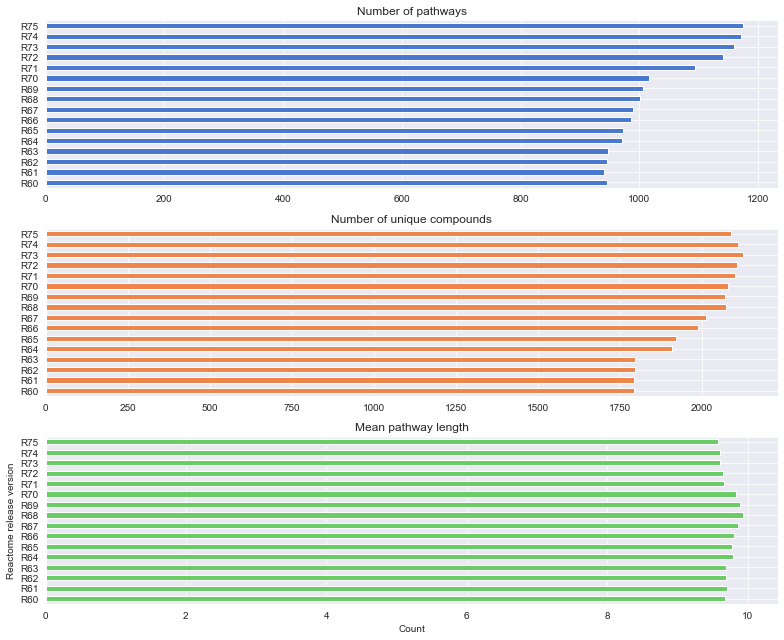

In [124]:
sns.set_style("darkgrid")
sns.set_palette("muted")
pathway_stats.plot.barh(figsize=(11, 9), subplots=True, sharex=False, sharey=True, legend=False)
plt.xlabel("Count")
plt.ylabel("Reactome release version")
plt.tight_layout()
# plt.savefig("../Figures/KEGG_years_comparison.png", dpi=300)

    Number of pathways Number of unique compounds Mean pathway length release  \
R60                945                       1792             9.68254     R60   
R61                941                       1792             9.70882     R61   
R62                945                       1797            9.689947     R62   
R63                947                       1795            9.700106     R63   
R64                970                       1908             9.78866     R64   

    Release  Year  
R60     R60  2020  
R61     R61  2020  
R62     R62  2020  
R63     R63  2020  
R64     R64  2020  


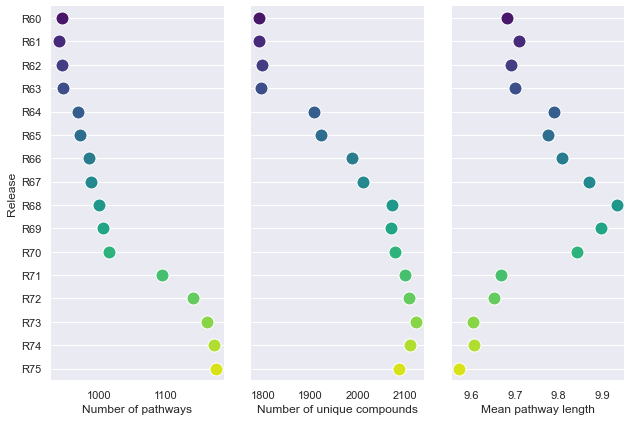

In [202]:
sns.set_style("darkgrid")
pathway_stats["Release"] = pathway_stats.index
pathway_stats["Year"] = 2020
g = sns.PairGrid(pathway_stats.sort_values('Release', ascending=True),
                 x_vars = pathway_stats.columns[0:3], y_vars='Release', height=6, aspect=.5)



# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=13, orient="h", jitter=False,
      palette="viridis", linewidth=1, edgecolor="w")

# Use semantically meaningful titles for the columns
# titles = ["a", "b", "c"]

for ax, title in zip(g.axes.flat, titles):
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    
# ax2 = plt.twinx()
# ax2.set_yticklabels(pathway_stats["Year"])

sns.despine(left=True, bottom=True)
# plt.savefig("../Figures/Reactome_version_comparison.png", dpi=600)
plt.show()

<a id='s5'></a>
## Metabolite misidentification

#### Random misidentification

In [ ]:
# Random misidentification
percentage_misidentifications = [i for i in range(0, 100, 10)]
def random_misidentification(db="KEGG"):
    results_lists = []
    d_sets = datasets
    if db == "Reactome":
        d_sets = datasets_reactome
    for d in d_sets.keys():
        print(d)
        if d.startswith("Zamboni"):
            for i in [i for i in range(0, 70, 10)]:
                print(i)
                res = utils.misidentify_metabolites(i, d_sets[d][4], d_sets[d][3], d_sets[d][1], d_sets[d][2],
                                                    zamboni=True)
                results_lists.append([d, i] + res[:-1])
        else:
            for i in percentage_misidentifications:
                print(i)
                res = utils.misidentify_metabolites(i, d_sets[d][4], d_sets[d][3], d_sets[d][1], d_sets[d][2])
                results_lists.append([d, i] + res[:-1])

    res_df = pd.DataFrame(results_lists, columns=["Dataset", "Percentage misidentification", "n_p_less_0.1", "n_q_less_0.1", "p_std", "q_std"])
    # res_df.to_csv("Metabolite_misidentification_simulation_random_Reactome.csv")

    simulation_res = res_df
    plt.figure()
    plt.style.use("seaborn")
    for i in d_sets.keys():
        plt.errorbar(simulation_res[simulation_res["Dataset"] == i]['Percentage misidentification'],
                     simulation_res[simulation_res["Dataset"] == i]['n_p_less_0.1'],
                     yerr=simulation_res[simulation_res["Dataset"] == i]['p_std'],
                     label=i, fmt='o', linestyle="solid", capsize=5,  markeredgewidth=2, markersize=4)
    plt.title("Reactome", fontsize=14)
    plt.legend()
    plt.ylabel("Mean number of pathways significant at P < 0.1 \n based on 100 random permutations")
    plt.xlabel("Percentage of metabolites misidentified")
    plt.savefig("metabolite_random_misidentification_Reactome2.png", dpi=300)
    plt.show()

random_misidentification(db="KEGG")

#### Misidentification by mass

In [ ]:
def misidentification_mass_plot(db="KEGG"):
    d_sets = datasets
    masses = KEGG_compounds_masses
    if db == "Reactome":
        d_sets = datasets_reactome
        masses = Reactome_compounds_masses
    results_lists = []
    for d in d_sets.keys():
        print(d)
        if d.startswith("Zamboni"):
            for i in d_sets[d][5]:
                print(i)
                res = utils.misidentify_metabolites_by_mass(i, d_sets[d][4], d_sets[d][2], masses,
                                                d_sets[d][3], zamboni=True)
                results_lists.append([d, i] + res)
        else:
            for i in d_sets[d][5]:
                print(i)
                res = utils.misidentify_metabolites_by_mass(i, d_sets[d][4], d_sets[d][2], masses,
                                                            d_sets[d][3], zamboni=False)
                results_lists.append([d, i] + res)

    res_df = pd.DataFrame(results_lists, columns=["Dataset", "Percentage misidentification", "n_p_less_0.1", "n_q_less_0.1", "p_std", "q_std", "sig_paths"])
    # res_df.to_csv("Metabolite_misidentification_by_mass_simulation_Reactome.csv")

    simulation_res = res_df
    print(simulation_res.head)
    plt.figure()
    plt.style.use("seaborn")
    for i in d_sets.keys():
        plt.errorbar(simulation_res[simulation_res["Dataset"] == i]['Percentage misidentification'],
                     simulation_res[simulation_res["Dataset"] == i]['n_p_less_0.1'],
                     yerr=simulation_res[simulation_res["Dataset"] == i]['p_std'],
                     label=i, fmt='o', linestyle="solid", capsize=5,  markeredgewidth=2, markersize=4)
    # plt.title("Number of pathways with P-values < 0.1 in response to \n varying levels of metabolite misidentification", fontsize=14)
    plt.legend()
    plt.ylabel("Mean number of pathways significant at P < 0.1")
    plt.xlabel("Percentage of metabolites misidentified by mass")
    plt.title("KEGG", fontsize=14)
    # plt.savefig("metabolite_misidentification_by_mass_Reactome.png", dpi=300)
    plt.show()

misidentification_mass_plot(db="KEGG")

#### Misidentification by chemical formula

In [ ]:
def misidentification_formula_plot(db="KEGG"):
    d_sets = datasets
    compounds = KEGG_compounds_masses
    if db == "Reactome":
        d_sets = datasets_reactome
        compounds = Reactome_compounds_masses
    results_lists = []
    for d in d_sets.keys():
        print(d)
        if d.startswith("Zamboni"):
            for i in d_sets[d][6]:
                print(i)
                res = utils.misidentify_metabolites_by_formula(i, d_sets[d][4], d_sets[d][2], compounds,
                                                d_sets[d][3], zamboni=True)
                results_lists.append([d, i] + res)
        else:
            for i in d_sets[d][6]:
                print(i)
                res = utils.misidentify_metabolites_by_formula(i, d_sets[d][4], d_sets[d][2], compounds,
                                                            d_sets[d][3], zamboni=False)
                results_lists.append([d, i] + res)

    res_df = pd.DataFrame(results_lists, columns=["Dataset", "Percentage misidentification", "n_p_less_0.1", "n_q_less_0.1", "p_std", "q_std", "sig_paths"])
    res_df.to_csv("Metabolite_misidentification_by_formula_simulation_Reactome.csv")

    simulation_res = res_df
    print(simulation_res.head)
    plt.figure()
    plt.style.use("seaborn")
    for i in d_sets.keys():
        plt.errorbar(simulation_res[simulation_res["Dataset"] == i]['Percentage misidentification'],
                     simulation_res[simulation_res["Dataset"] == i]['n_p_less_0.1'],
                     yerr=simulation_res[simulation_res["Dataset"] == i]['p_std'],
                     label=i, fmt='o', linestyle="solid", capsize=5,  markeredgewidth=2, markersize=4)
    plt.title("Reactome", fontsize=14)
    plt.legend()
    plt.ylabel("Mean number of pathways significant at P < 0.1")
    plt.xlabel("Percentage of metabolites misidentified by formula")
    plt.savefig("metabolite_misidentification_by_formula_Reactome.png", dpi=300)
    plt.show()

misidentification_formula_plot(db="KEGG")

### Pathway re-discovery and pathway mis-discovery rate

In [223]:
# Parameter grid for TPR/FPR heatmaps. Numbers correspond to indexes in datasets param grids.
param_grid_heatmaps = {"random": [utils.misidentify_metabolites, 4, 3, 1, 2, [i for i in range(0, 70, 10)]],
                       "mass": [utils.misidentify_metabolites_by_mass, 4, 2, 7, 3, [i for i in range(1, 7, 1)]],
                       "formula": [utils.misidentify_metabolites_by_formula, 4, 2, 7, 3, [i for i in range(1, 6, 1)]]}

def TPR_heatmap(pg, fname, db="KEGG"):
    """
    Plots TRP/FPR heatmap
    :param misidenetification_funct: function for misidentification
    :param db: Database, default is KEGG
    :return: heatmap
    """
    d_sets = datasets
    if db == "Reactome":
        d_sets = datasets_reactome
    results_TPR = []
    results_FPR = []
    for d in ["Auwerx", "Brown", "Yamada", "Zamboni (dcuS)", "Zamboni (yfgM)"]:
        print(d)
        if d.startswith("Zamboni"):
            original_pathways = pg[0](0, d_sets[d][pg[1]], d_sets[d][pg[2]], d_sets[d][pg[3]], d_sets[d][pg[4]],
                                                    zamboni=True)[4][0]

            for i in pg[5]:
                print(i)
                res = pg[0](i, d_sets[d][pg[1]], d_sets[d][pg[2]], d_sets[d][pg[3]], d_sets[d][pg[4]],
                                                    zamboni=True)[4]
                misidentified_pathways = res
                pathway_fractions_TPR = []
                pathway_fractions_FPR = []
                for x in misidentified_pathways:
                    total_significant_paths = len(original_pathways) # True positive + false positive
                    number_common_paths = len([i for i in x if i in original_pathways])
                    fraction_pathways_TPR = number_common_paths/total_significant_paths
                    pathway_fractions_TPR.append(fraction_pathways_TPR)
                    fraction_pathways_FPR = len([i for i in x if i not in original_pathways])/total_significant_paths
                    pathway_fractions_FPR.append(fraction_pathways_FPR)
                avg_fraction_TPR = np.mean(pathway_fractions_TPR)
                avg_fraction_FPR = np.mean(pathway_fractions_FPR)
                results_TPR.append([d, i, avg_fraction_TPR])
                results_FPR.append([d, i, avg_fraction_FPR])

        else:
            original_pathways = pg[0](0, d_sets[d][pg[1]], d_sets[d][pg[2]], d_sets[d][pg[3]], d_sets[d][pg[4]], zamboni=False)[4][0]
            for i in pg[5]:
                print(i)
                res = pg[0](i, d_sets[d][pg[1]], d_sets[d][pg[2]], d_sets[d][pg[3]], d_sets[d][pg[4]], zamboni=False)[4]
                misidentified_pathways = res
                pathway_fractions_TPR = []
                pathway_fractions_FPR = []
                for x in misidentified_pathways:
                    total_significant_paths = len(original_pathways) # True positive + false positive
                    number_common_paths = len([i for i in x if i in original_pathways])
                    fraction_pathways_TPR = number_common_paths/total_significant_paths
                    pathway_fractions_TPR.append(fraction_pathways_TPR)
                    fraction_pathways_FPR = len([i for i in x if i not in original_pathways])/total_significant_paths
                    pathway_fractions_FPR.append(fraction_pathways_FPR)
                avg_fraction_TPR = np.mean(pathway_fractions_TPR)
                avg_fraction_FPR = np.mean(pathway_fractions_FPR)
                results_TPR.append([d, i, avg_fraction_TPR])
                results_FPR.append([d, i, avg_fraction_FPR])
    res_df_TPR = pd.DataFrame(results_TPR,
                          columns=["Dataset", "Percentage misidentification", "Average fraction"])
    res_df_FPR = pd.DataFrame(results_FPR,
                              columns=["Dataset", "Percentage misidentification", "Average fraction"])

    print(res_df_FPR)
#     res_df_TPR = res_df_TPR.pivot(index='Percentage misidentification', columns='Dataset', values='Average fraction')
#     res_df_FPR = res_df_FPR.pivot(index='Percentage misidentification', columns='Dataset', values='Average fraction')
    # res_df = pd.read_csv("metabolite_misidentification_heatmap.csv", index_col=0)
    plt.style.use("seaborn")
    plt.figure(figsize=(9, 5))
    plt.subplot(121)
    plt.title('TPR')
    sns.heatmap(res_df_TPR, annot=True, cmap="mako", square=True)
    plt.subplot(122)
    plt.title('FPR')
    sns.heatmap(res_df_FPR, annot=True, cmap="rocket_r", square=True)
    plt.subplots_adjust(bottom=0.28)
        # plt.ylabel("Percentage metabolite misidentification (%)")
    plt.savefig(fname, dpi=300)
    plt.show()

# TPR_heatmap(param_grid_heatmaps["random"], "random_misidentification_heatmap_KEGG_new.png", db="KEGG")
# TPR_heatmap(param_grid_heatmaps["formula"], "formula_misidentification_heatmap_KEGG_new.png", db="KEGG")
# TPR_heatmap(param_grid_heatmaps["mass"], "mass_misidentification_heatmap_KEGG_new.png", db="KEGG")

In [4]:
param_grid_heatmaps = {"random": [utils.misidentify_metabolites, 4, 3, 1, 2, [i for i in range(0, 70, 10)]],
                       "mass": [utils.misidentify_metabolites_by_mass, 4, 2, 7, 3, [i for i in range(1, 7, 1)]],
                       "formula": [utils.misidentify_metabolites_by_formula, 4, 2, 7, 3, [i for i in range(1, 6, 1)]]}


def misidentification_barplot(pg, db="KEGG"):

    """
    Plots TRP/FPR heatmap
    :param misidenetification_funct: function for misidentification
    :param db: Database, default is KEGG
    :return: heatmap
    """
    d_sets = datasets
    if db == "Reactome":
        d_sets = datasets_reactome
    results_TPR = []
    results_FPR = []
    for d in d_sets.keys():
        print(d)
        if d.startswith("Fuhrer"):
            original_pathways = pg[0](0, d_sets[d][pg[1]], d_sets[d][pg[2]], d_sets[d][pg[3]], d_sets[d][pg[4]],
                                      zamboni=True)[4][0]

            for i in [4]:
                print(i)
                res = pg[0](i, d_sets[d][pg[1]], d_sets[d][pg[2]], d_sets[d][pg[3]], d_sets[d][pg[4]],
                            zamboni=True)[4]
                misidentified_pathways = res
                pathway_fractions_TPR = []
                pathway_fractions_FPR = []
                for x in misidentified_pathways:
                    total_significant_paths = len(original_pathways)  # True positive + false positive
                    number_common_paths = len([i for i in x if i in original_pathways])
                    fraction_pathways_TPR = 1-(number_common_paths / total_significant_paths)
                    pathway_fractions_TPR.append(fraction_pathways_TPR)
                    fraction_pathways_FPR = len(
                        [i for i in x if i not in original_pathways]) / total_significant_paths
                    pathway_fractions_FPR.append(fraction_pathways_FPR)
                avg_fraction_TPR = np.mean(pathway_fractions_TPR)
                sem_TPR = np.std(pathway_fractions_TPR)
                avg_fraction_FPR = np.mean(pathway_fractions_FPR)
                sem_FPR = np.std(pathway_fractions_FPR)
                results_TPR.append([d, i, avg_fraction_TPR, sem_TPR])
                results_FPR.append([d, i, avg_fraction_FPR, sem_FPR])

        else:
            original_pathways = \
                pg[0](0, d_sets[d][pg[1]], d_sets[d][pg[2]], d_sets[d][pg[3]], d_sets[d][pg[4]], zamboni=False)[4][
                    0]
            for i in [4]:
                print(i)
                res = \
                pg[0](i, d_sets[d][pg[1]], d_sets[d][pg[2]], d_sets[d][pg[3]], d_sets[d][pg[4]], zamboni=False)[4]
                misidentified_pathways = res
                pathway_fractions_TPR = []
                pathway_fractions_FPR = []
                for x in misidentified_pathways:
                    total_significant_paths = len(original_pathways)  # True positive + false positive
                    number_common_paths = len([i for i in x if i in original_pathways])
                    fraction_pathways_TPR = 1-(number_common_paths / total_significant_paths)
                    pathway_fractions_TPR.append(fraction_pathways_TPR)
                    fraction_pathways_FPR = len(
                        [i for i in x if i not in original_pathways]) / total_significant_paths
                    pathway_fractions_FPR.append(fraction_pathways_FPR)
                avg_fraction_TPR = np.mean(pathway_fractions_TPR)
                sem_TPR = stats.sem(pathway_fractions_TPR)
                avg_fraction_FPR = np.mean(pathway_fractions_FPR)
                sem_FPR = stats.sem(pathway_fractions_FPR)
                results_TPR.append([d, i, avg_fraction_TPR, sem_TPR])
                results_FPR.append([d, i, avg_fraction_FPR, sem_FPR])
    res_df_TPR = pd.DataFrame(results_TPR,
                              columns=["Dataset", "Percentage misidentification", "Average fraction", "SEM"])
    res_df_FPR = pd.DataFrame(results_FPR,
                              columns=["Dataset", "Percentage misidentification", "Average fraction", "SEM"])

    return res_df_TPR, res_df_FPR


mass_TPR, mass_FPR = misidentification_barplot(param_grid_heatmaps["mass"], db="KEGG")
formula_TPR, formula_FPR = misidentification_barplot(param_grid_heatmaps["formula"], db="KEGG")


Labbé
4
Yachida
4
Stevens
4
Quirós
4
Fuhrer (yfgM)
4
Fuhrer (dcuS)
4
Labbé
4
Yachida
4
Stevens
4
Quirós
4
Fuhrer (yfgM)
4
Fuhrer (dcuS)
4


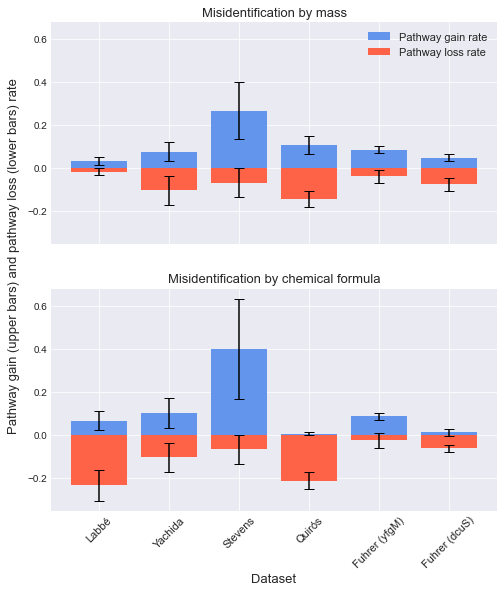

In [16]:
plt.style.use("seaborn-darkgrid")
plt.rc('xtick',labelsize=11)

fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 9), sharex=True, sharey=True)

ax1.bar(mass_FPR["Dataset"].tolist(), mass_FPR["Average fraction"],
        yerr=mass_FPR["SEM"], capsize=5, label="Pathway gain rate", color="cornflowerblue")
ax1.bar(mass_TPR["Dataset"].tolist(), -mass_TPR["Average fraction"],
        yerr=mass_TPR["SEM"], capsize=5, label="Pathway loss rate", color="tomato")
ax1.set_title("Misidentification by mass", fontsize=13)

ax2.bar(formula_FPR["Dataset"].tolist(), formula_FPR["Average fraction"],
        yerr=formula_FPR["SEM"], capsize=5, label="Pathway gain rate", color="cornflowerblue")
ax2.bar(formula_TPR["Dataset"].tolist(), -formula_TPR["Average fraction"],
        yerr=formula_TPR["SEM"], capsize=5, label="Pathway loss rate", color="tomato")
ax2.set_title("Misidentification by chemical formula", fontsize=13)

ax2.set_xlabel("Dataset", fontsize=13)
fig.text(0.06, 0.25, "Pathway gain (upper bars) and pathway loss (lower bars) rate", fontsize=13, ha='center', rotation="vertical")
ax1.legend(fontsize=11)
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)
plt.savefig("../Figures/pathway_gain_loss_mass_formula_4_pct.png", dpi=600)
plt.show()


         Dataset  Percentage misidentification  Average fraction       SEM
0          Labbé                             5          0.050000  0.070711
1        Yachida                             5          0.153846  0.166173
2        Stevens                             5          0.133333  0.094281
3         Quirós                             5          0.108844  0.097637
4  Fuhrer (yfgM)                             5          0.111111  0.000000
5  Fuhrer (dcuS)                             5          0.037037  0.000000


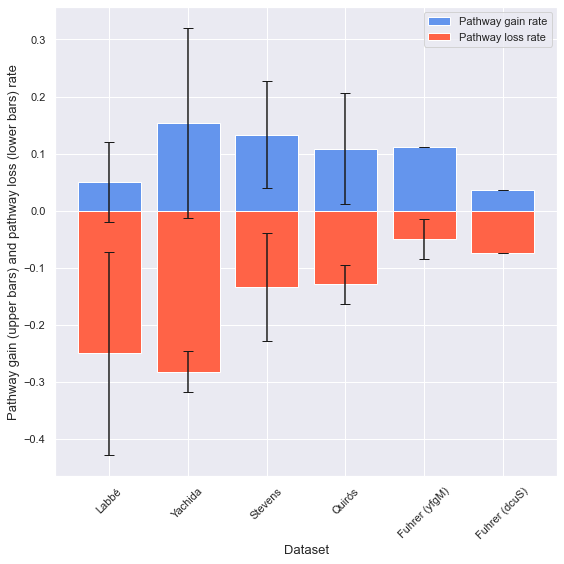

In [241]:
print(res_df_FPR)

plt.figure(figsize=(8,8))
plt.bar(res_df_FPR["Dataset"].tolist(), res_df_FPR["Average fraction"],
        yerr = res_df_FPR["SEM"], capsize=5, label="Pathway gain rate", color="cornflowerblue")
plt.bar(res_df_TPR["Dataset"].tolist(), -res_df_TPR["Average fraction"],
        yerr = res_df_TPR["SEM"], capsize=5, label="Pathway loss rate", color="tomato")
plt.ylabel("Pathway gain (upper bars) and pathway loss (lower bars) rate", fontsize=13)
plt.xlabel("Dataset", fontsize=13)
plt.legend(fontsize=11)
plt.xticks(rotation = 45)
plt.tight_layout()
plt.savefig("../Figures/pathway_gain_loss_mass.png", dpi=600)
plt.show()


<a id='s6'></a>
## Metabolite polarity

In [11]:
from matplotlib_venn import venn2

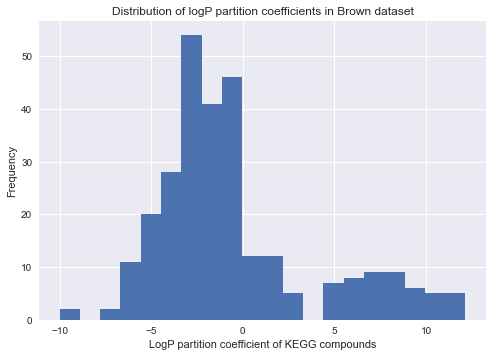

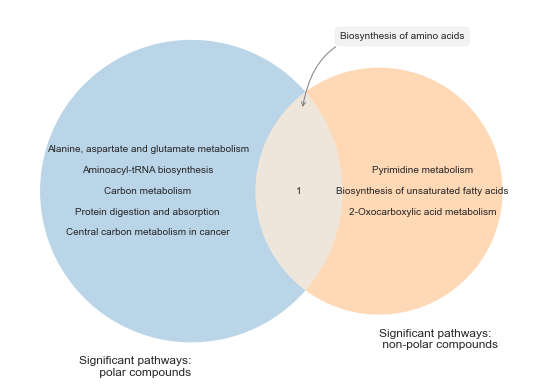

In [12]:
logp_all = pd.read_csv("hmdb_logp_all.csv", index_col=0)

# DEM_auwerx, background_auwerx, mat_auwerx = process_datasets.auwerx_data(db="KEGG")
# DEM_yamada, background_yamada, mat_yamada = process_datasets.yamada_data(db="KEGG")
# DEM_stevens, background_stevens, mat_stevens = process_datasets.stevens_data(db="KEGG")
DEM_brown, background_brown, mat_brown = process_datasets.brown_data(db="KEGG")
# DEM_yfgM, background_yfgM, mat_yfgM = process_datasets.zamboni_data("yfgM", db="KEGG")
# DEM_dcuS, background_dcuS, mat_dcuS = process_datasets.zamboni_data("dcuS", db="KEGG")

KEGG_mouse_pathways = pd.read_csv("KEGG_mouse_pathways_compounds.csv", dtype=str, index_col=0)
# KEGG_human_pathways = pd.read_csv("KEGG_human_pathways_compounds.csv", dtype=str, index_col=0)
# KEGG_eco_pathways = pd.read_csv("KEGG_ecoMG1655_pathways_compounds.csv", dtype=str, index_col=0)

cols = mat_brown.columns.tolist()
matching_id = logp_all[logp_all["kegg_id"].isin(cols)]
plt.style.use("seaborn")
plt.hist(matching_id["logp"], bins=20)
plt.xlabel("LogP partition coefficient of KEGG compounds")
plt.ylabel("Frequency")
plt.title("Distribution of logP partition coefficients in Brown dataset")
plt.show()

# Brown - split at -1 or -2
def log_p_venn(cutoff, mat, pathways):
    polar = matching_id[matching_id["logp"] < cutoff]
    nonpolar = matching_id[matching_id["logp"] > cutoff]

    polar_mat = mat.filter(polar["kegg_id"])
    polar_mat = polar_mat.iloc[:, ~polar_mat.columns.duplicated()]
    ttest_polar = utils.t_tests(polar_mat, mat["Group"], "fdr_bh")
    dem_polar = ttest_polar[ttest_polar["P-adjust"] <= 0.05]["Metabolite"].tolist()
    ora_polar = utils.over_representation_analysis(dem_polar, polar_mat.columns.tolist(), pathways)

    nonpolar_mat = mat.filter(nonpolar["kegg_id"])
    nonpolar_mat = nonpolar_mat.iloc[:, ~nonpolar_mat.columns.duplicated()]
    ttest_nonpolar = utils.t_tests(nonpolar_mat, mat["Group"], "fdr_bh")
    dem_nonpolar = ttest_nonpolar[ttest_nonpolar["P-adjust"] <= 0.05]["Metabolite"].tolist()
    ora_nonpolar = utils.over_representation_analysis(dem_nonpolar, nonpolar_mat.columns.tolist(), pathways)

    polar_pathways = ora_polar[ora_polar["P-value"] <= 0.1]["Pathway_ID"].tolist()
    nonpolar_pathways = ora_nonpolar[ora_nonpolar["P-value"] <= 0.1]["Pathway_ID"].tolist()
    common_paths = list(set(polar_pathways) & set(nonpolar_pathways))

    pp_names = [' '.join(i.split(' ')[:-4]) for i in ora_polar[ora_polar["P-value"] <= 0.1]["Pathway_name"].tolist()]
    np_names = [' '.join(i.split(' ')[:-4]) for i in ora_nonpolar[ora_nonpolar["P-value"] <= 0.1]["Pathway_name"].tolist()]
    common_names = list(set(pp_names) & set(np_names))

    plt.style.use("seaborn")
    venn = venn2(subsets = (set(polar_pathways),
                            set(nonpolar_pathways)), set_labels = ('Significant pathways:\n polar compounds', 'Significant pathways:\n non-polar compounds'),
                 set_colors=('tab:blue', 'tab:orange'), alpha = 0.3)
    venn.get_label_by_id('100').set_text("\n\n".join([i for i in pp_names if i not in common_names]))
    venn.get_label_by_id('010').set_text("\n\n".join([i for i in np_names if i not in common_names]))
    plt.annotate("\n".join(common_names), xy=venn.get_label_by_id('110').get_position() - np.array([-0.01, -0.25]), xytext=(100,70),
    ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray', linewidth=1))

    plt.tight_layout()
    # plt.savefig("../Figures/logp_brown_venn.png", dpi=300)
    plt.show()

log_p_venn(-2, mat_brown, KEGG_mouse_pathways)